<b>Dans ce notebook on réalise une analyse exploratoire du dataset.</b>

# Table of contents
1. [Load clean dataset](#load)
2. [Analyses univariées](#def_features)
3. [Analyses univariées](#univariate)
4. [Analyses bivariées](#bivariate)

    4.1 [Analyse de corrélation par feature scoring](#correl_feature_scoring)

    4.2 [Analyse du score nutritionnel par groupe de produit ](#eval_nutri_categ)

5. [Analyses explicatives](#expl)

    5.1 [Influence du facteur bio](#bio)
    
    5.2 [Influence du facteur sous groupe sur le nutriscore](#facteur_groupe)
    
    5.3 [Analyse des features de scoring par sous groupes](#feature_scoring)
        
    5.3.1 [Energie](#feature_scoring_energy)
        
    5.3.2 [Sucre](#feature_scoring_sugar)
        
    5.3.3 [Acides gras saturés](#feature_scoring_saturated_fat)
       
    5.3.4 [Sel](#feature_scoring_salt)
        
    5.3.5 [Fruits, légumes, oléagineux](#feature_scoring_fruits)
        
    5.3.6 [Fibres](#feature_scoring_fibers)
        
    5.3.7 [Protéines](#feature_scoring_proteins)
        
    5.3.8 [Synthèse](#feature_scoring_synth)

6. [Analyse factorielle](#factorial) 

7. [Simulation d'application](#application) 


<b style="background-color:tomato;font-size:14px;">1. LOAD CLEAN DATASET<b>
    <a id="load"></a> 

In [1]:
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

import scipy.stats as stats
import pylab as pl

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
import matplotlib.font_manager

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
import re
from tabulate import tabulate
from scipy.stats import kruskal
import math

try:
    del data
except:
    dummy=1

#On reprend le dataset issu du clean
#data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',nrows=300000, low_memory=False)
data=pd.read_csv('../dataset/consolidated-167273.csv',sep='\t',nrows=300000, low_memory=False)

columns_to_remove = []
columns_to_remove = [c for c in data.columns if (re.match('^-',c.lower()))]

print('data shape before removal: ' + str(data.shape))
data.drop(columns_to_remove, axis = 1, inplace = True)
print('data shape after removal: ' + str(data.shape))

data shape before removal: (167270, 163)
data shape after removal: (167270, 128)


<b style="background-color:tomato;font-size:14px;">2. DEFINITION DES FEATURES DE SCORING<b>
    <a id="def_features"></a> 

On valorise un tableau des features de scoring nutritionnel tels qu'on les a définies dans le notebook Discover.

In [2]:
scoring_features = ['energy-kcal_100g',
 'saturated-fat_100g',
'salt_100g',
'sugars_100g',
'fiber_100g',
'proteins_100g',
'fruits-vegetables-nuts_100g']
scoring_features

['energy-kcal_100g',
 'saturated-fat_100g',
 'salt_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'fruits-vegetables-nuts_100g']

<b style="background-color:tomato;font-size:14px;">3. ANALYSES UNIVARIEES<b>
    <a id="univariate"></a> 

<Figure size 1440x360 with 0 Axes>

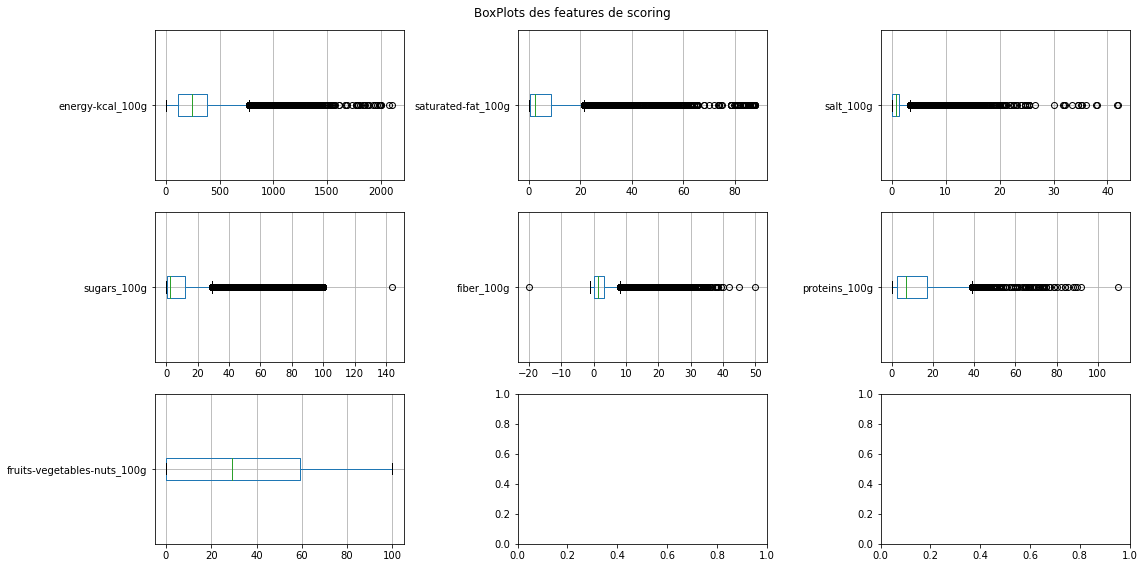

In [8]:
plt.figure(figsize=(20,5))

fig, axes = plt.subplots(3,3, figsize=(16,8))

plt.suptitle("BoxPlots des features de scoring")
for i, ax in zip(range(7), axes.flat):
    data.boxplot(column=[scoring_features[i]], ax=axes.flatten()[i],vert=False)
    
plt.tight_layout()    

plt.show() 



<p>En mettant de côté les outliers, on peut commenter la distribution de ces features comme suit :<p>
    
<table>
    <tr>
       <td align="center" bgcolor="blue">Feature</td>
        <td align="center" bgcolor="blue">Centrage</td>
        <td align="center" bgcolor="blue">IQR</td>        
        <td align="center" bgcolor="blue">Commentaires</td>
    </tr>    
    <tr>
        <td>energy-kcal_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Petit</td>
        <td>Les valeurs sont centrées sur la médiane</td>
    </tr>
    <tr>
        <td>saturated-fat_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Petit</td>
        <td>Les valeurs sont centrées sur la médiane</td>
    </tr>
    <tr>
        <td>salt_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Très petit</td>
        <td>Les valeurs sont très centrées sur la médiane</td>
    </tr>    
    <tr>
        <td>sugars_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Petit</td>
        <td>Les valeurs sont centrées sur la médiane</td>
    </tr>
    <tr>
        <td>fiber_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Très petit</td>
        <td>Les valeurs sont très centrées sur la médiane</td>
    </tr>
    <tr>
        <td>proteins_100g</td>
        <td>Distribution modale asymétrique décentrée vers la valeur minimum</td>
        <td>Petit</td>
        <td>Les valeurs sont centrées sur la médiane</td>
    </tr>
    <tr>
        <td>fruits-vegetables-nuts_100g</td>
        <td>Distribution modale légèrement asymétrique décentrée vers la valeur minimum</td>
        <td>Large</td>
        <td>Les valeurs sont très dispersées autour de la médiane. La feature pourrait être correspondre à une distribution normale, à vérifier par le calcul</td>
    </tr>
    
</table>   



La description de forme de la distribution des features nous amène à vérifier par un test de Shapiro que l'hypothèse nulle qui consiste à supposer que la distribution est normale peut être rejetée si la p-value calculée est inférieure au seuil de 5%.

In [59]:
details=[]
details.append(['Feature','p-value','Normality check with Shapiro test'])

for feat in scoring_features:
    checknormality=True
    u=data[data[feat].notna()]
    p_value = stats.shapiro(u[feat].iloc [0:5000, ])[1]
    if p_value < 0.05:
        checknormality=False
    if checknormality ==True:
        details.append([feat,str(p_value),' satisfied'])
    else:
        details.append([feat,str(p_value),' not satisfied'])
                        
print(tabulate(details))                       

---------------------------  ----------------------  ---------------------------------
Feature                      p-value                 Normality check with Shapiro test
energy-kcal_100g             3.2072498861927116e-40  not satisfied
saturated-fat_100g           0.0                     not satisfied
salt_100g                    0.0                     not satisfied
sugars_100g                  0.0                     not satisfied
fiber_100g                   0.0                     not satisfied
proteins_100g                0.0                     not satisfied
fruits-vegetables-nuts_100g  3.3072653220063525e-38  not satisfied
---------------------------  ----------------------  ---------------------------------


<p>Au seuil de 0.05 l'hypothèse nulle est rejetée, c'est à dire qu'aucune des distributions de feature scoring ne suit la loi normale.</p>
<p> Les valeurs étant très proches de 0, l'hypothèse nulle serait également rejetée pour des seuils inférieurs. Il nous faudra aborder les analyses statistiques en tenant compte de ce constat. </p>
<p>Il sera important de valider l'homoscedasticité des groupes pour mener des analyses de variance.</p>

<b style="background-color:tomato;font-size:14px;">4. ANALYSES BIVARIEES<b>
    <a id="bivariate"></a> 

<b style="background-color:tomato;font-size:12px;">4.1 Analyse de corrélation par feature scoring<b>
    <a id="correl_feature_scoring"></a> 

In [18]:
def plotCorrelationMatrix(feature,title):
    corrmat = data.corr()
    sns.set(context="paper", font_scale = 1.2)
    f, ax = plt.subplots(figsize=(11, 11))
    cols = corrmat.nlargest(25, feature)[feature].index
    cm = corrmat.loc[cols, cols] 
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                     fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                     yticklabels=cols.values, xticklabels=cols.values)
    f.text(0.5, 0.93, title, ha='center', fontsize = 18)
    plt.show()

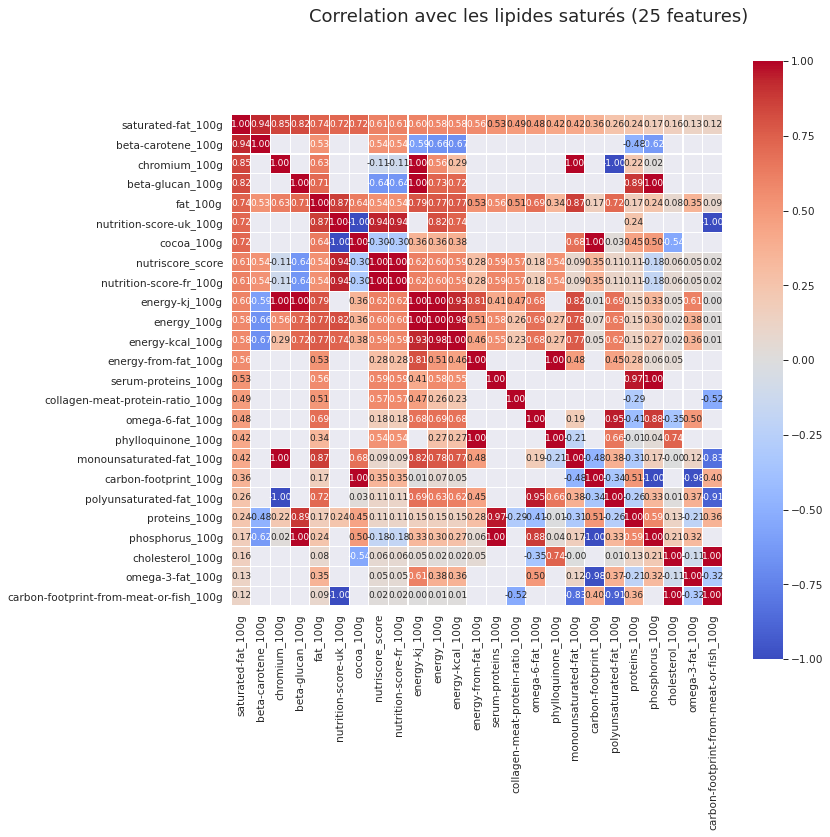

In [19]:
plotCorrelationMatrix('saturated-fat_100g','Correlation avec les lipides saturés (25 features)')

<p>On retrouve la confirmation de la correlation positive lipides / différents types (saturés et insaturés) avec une corrélation plus forte pour les lipides insaturés (oméga). </p>
<p>On peut déjà en déduire que le score nutritionnel est un bon indicateur de la représentativité des différentes formes de lipides (bon vs mauvais gras). </p>
<p>A noter le cacao qui apparait comme très fortement correlé aux lipides, mais lui même très fortement correlé aux lipides saturés qui ne sont pas vraiment recommandés (on s'en doutait un petit peu, mais c'est si bon !)</p>
<p>Au niveau des corrélations négatives on retrouve de façon très marquée l'ingrédient serum-protein en interaction avec le nutriscore. Un avis d'expertise nutritionnelle pourrait certainement nous en expliquer la raison.</p>

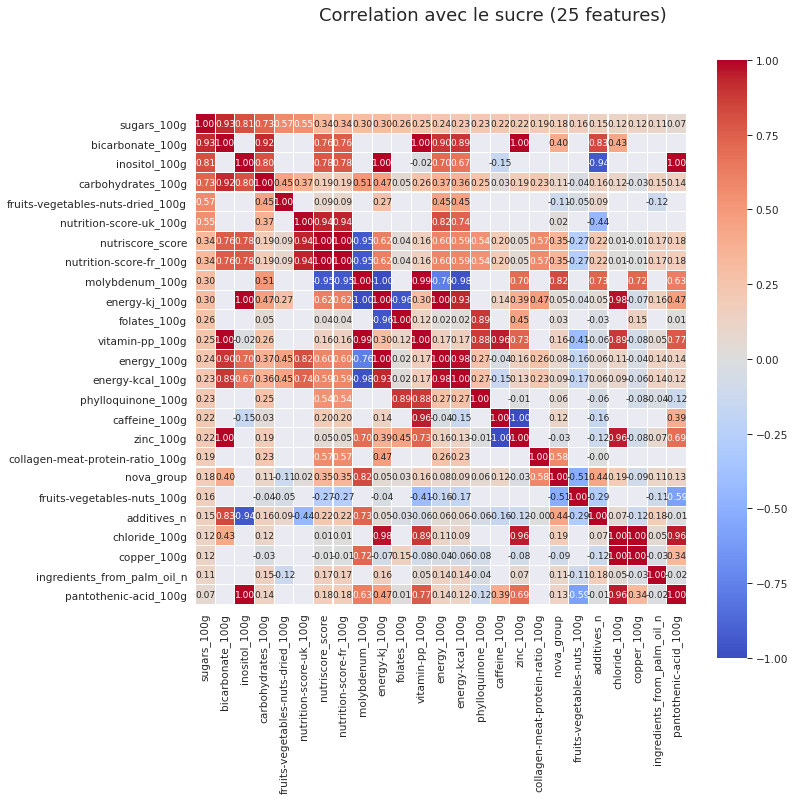

In [20]:
plotCorrelationMatrix('sugars_100g','Correlation avec le sucre (25 features)')

<p>Le sucre est fortement positivement correlé aux glucides (carbohydrates_100g) ainsi qu'aux fruits et légumes sechés (fruits-vegetables-nuts-dried_100g) ce qui nous indique que les produits ayant une forte proportion de cet ingrédient seront en contradiction avec les recommandations du ministère.</p><p>
Inversement on remarque qu'il n'y a pas de corrélation marquée avec les fruits légumes non séchés (fruits-vegetables-nuts_100g) <p>

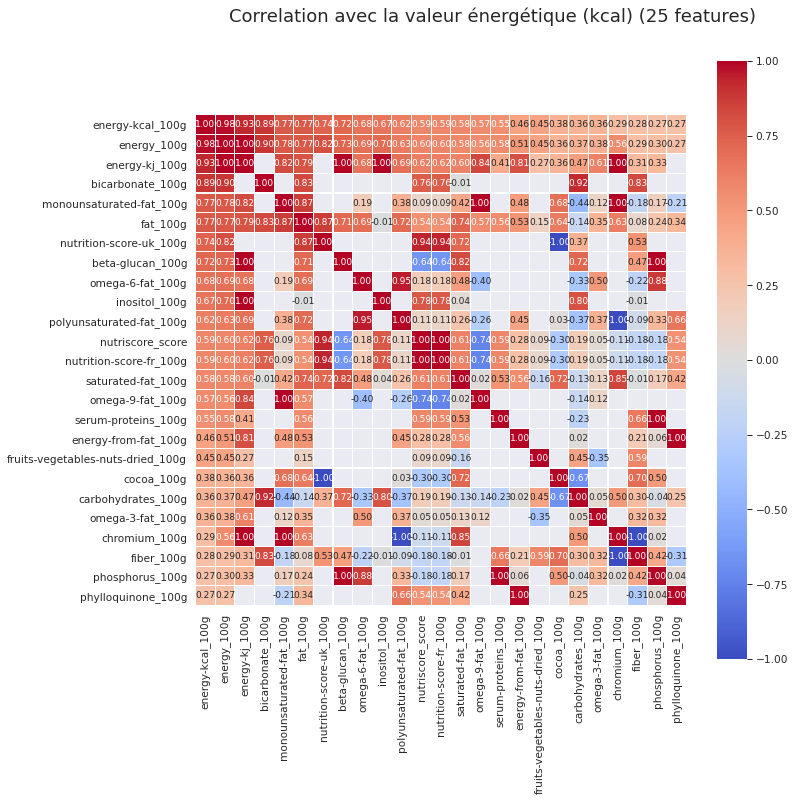

In [21]:
plotCorrelationMatrix('energy-kcal_100g','Correlation avec la valeur énergétique (kcal) (25 features)')

<p>On trouve principalement des corrélations positives fortes à modérées avec la famille des lipides.</p>
<p>On constate également une corrélation modérée avec les fruits et légumes et noix séchés, cela peut s'expliquer par leur part élevée en sucres (voir point précédent), ainsi que par certains individus comme les noix, amandes, noisettes qui sont riches en lipides</p>
<p>Il faudra donc bien prendre en compte cette spécificité dans les propositions d'alternatives de produit ou d'ingrédient.</p>

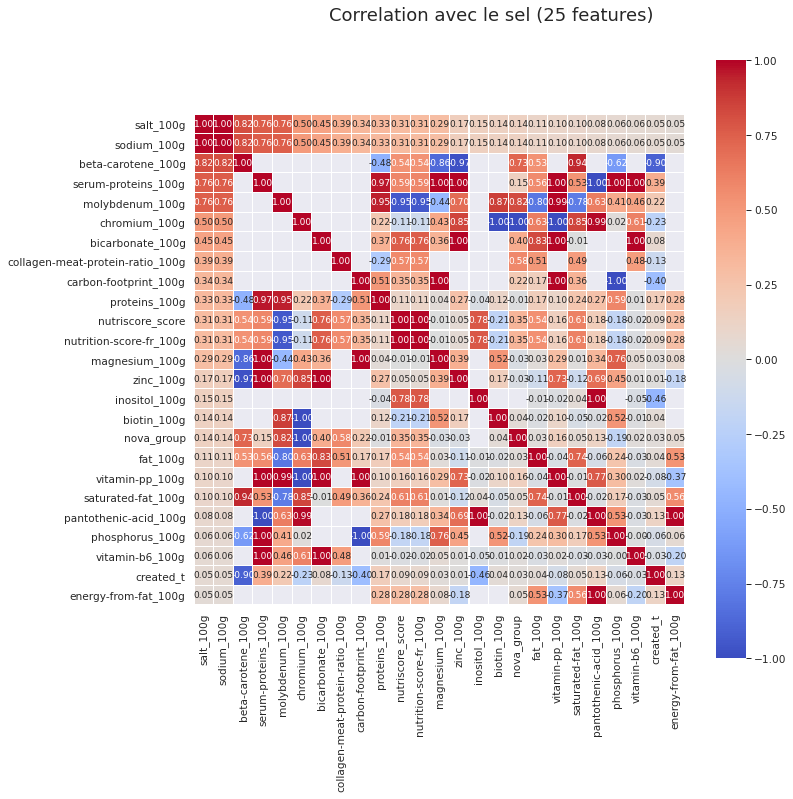

In [22]:
plotCorrelationMatrix('salt_100g','Correlation avec le sel (25 features)')

<p>Le sel ne montre pas de corrélation significative, il se retrouve dans les produits mais n'interagit pas significativement sur les autres ingrédients ou sur le score nutritionnel.</p>
<p>Il agit un peu comme un ingrédient fantôme, pourtant il est bien référencé par le ministère comme étant à réduire. </p>
<p>On peut conclure que le sel n'est pas suffisamment pris en compte dans le calcul du score nutritionnel (on devrait constater une corrélation négative au moins).</p>

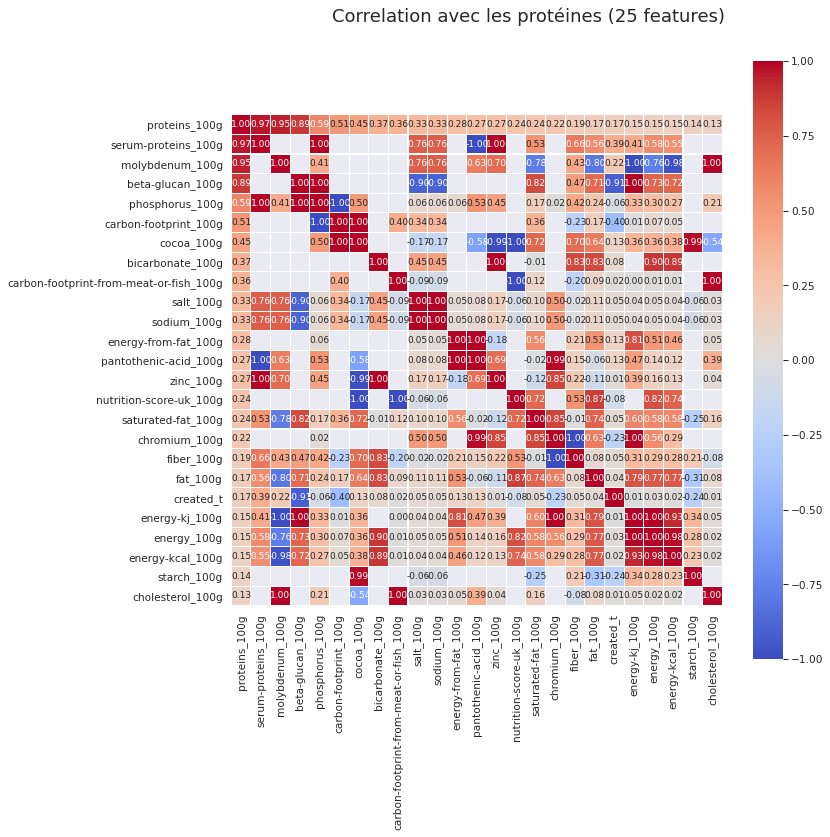

In [23]:
plotCorrelationMatrix('proteins_100g','Correlation avec les protéines (25 features)')

<p>Les protéines présentent une corrélation positive forte avec l'ingrédient serum-proteins_100g qui indique un lien fort avec la viande animale. La source essentielle de protéine dans les produits du dataset est donc la viande.</p>
<p>On note une corrélation modérée avec l'empreinte carbone (carbon-footprint_100g). On perçoit à travers ce constat que les protéines d'origine animale entraine une empreinte carbone. En allant dans le sens des recommandations du ministère qui préconise de diminuer la viande on agit en même temps sur ce facteur. Cela peut constituer un argument séduisant ou incitant.</p>

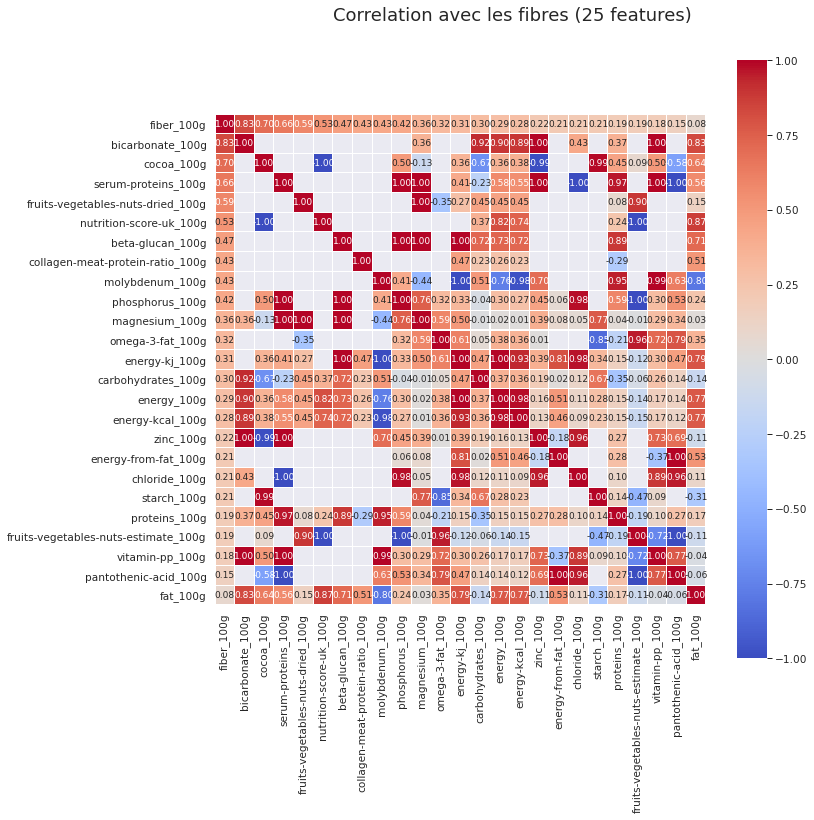

In [24]:
plotCorrelationMatrix('fiber_100g','Correlation avec les fibres (25 features)')

<p>On constate une corrélation positive forte avec le bicarbonate (explication nutritionnelle ???) </p>
<p>Les autres corrélations fortes sont la viande, le cacao et les fruits-légumes-noix séchés</p>
<p>Il sera donc intéressant, dans la perspective de préconiser une augmentation de la part de fibre de conseiller la consommation modérée de fruits-légumues-noix séchés (modérée car par ailleurs on a vu que la part de sucre était importante)</p>

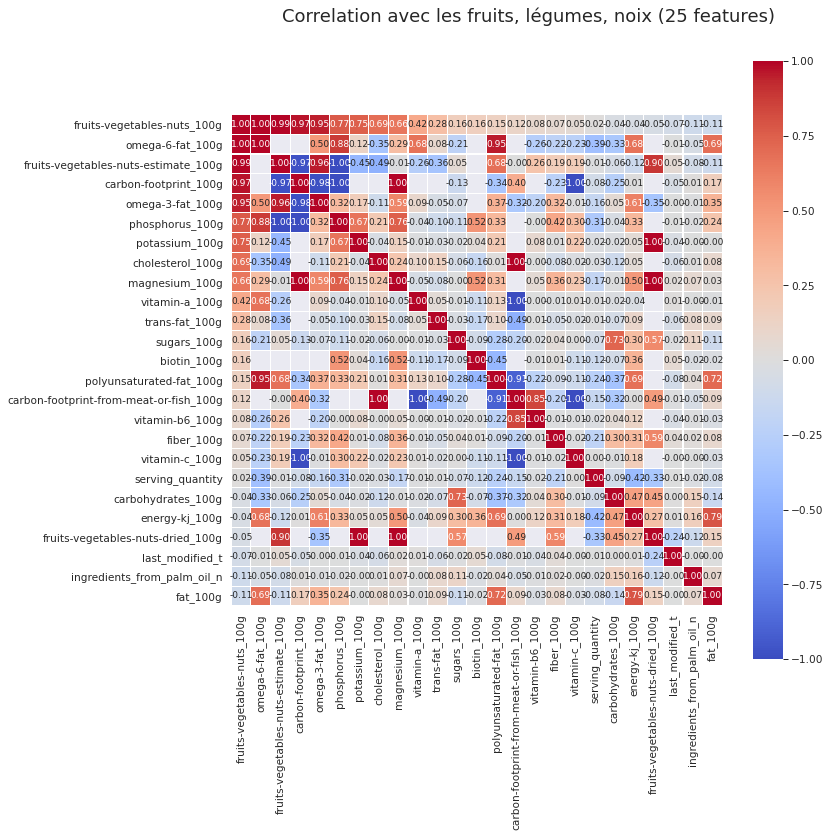

In [25]:
plotCorrelationMatrix('fruits-vegetables-nuts_100g','Correlation avec les fruits, légumes, noix (25 features)')

<p>On constate une corrélation positive forte avec les lipides de la famille des oméga qui sont déclarés comme bons pour la santé. Il sera donc judicieux de conseiller les produits riches en ingrédients de cette famille.</p>
<p>Etonnamment on constate aussi une corrélation positive forte avec l'empreinte carbone. Cela nous indique que les produits contenant une bonne part de fruits-légumes-noix ont par héritage une empreinte carbone significative. On peut avancer l'hypothèse que cette empreinte carbone est due au fait que les fruits légumes noix sont des aliments récoltés et transportés.</p>
<p>On peut souligner l'absence de corrélation avec le sucre, ce qui nous donne une piste d'alternative de substitut par un fruit pour un dessert trop sucré par exemple.</p>

<b style="background-color:tomato;font-size:12px;">4.2 Analyse du score nutritionnel par groupe de produit <b>
    <a id="eval_nutri_categ"></a> 

<p>La feature "pnns_groups_1" constitue un regroupement général des produits qui permet de décrire à la fois leur utilisation et leur contenu.</p>
<p>On voudrait étudier comment est réparti la valeur du nutriscore par rapport à cette feature, et déduire s'il existe une correlation entre ces deux features.</p>

In [5]:
data['pnns_groups_1'].unique()

array(['Fat and sauces', 'Composite foods', 'Sugary snacks',
       'Fruits and vegetables', 'Fish Meat Eggs', 'Beverages',
       'Milk and dairy products', 'Cereals and potatoes', 'Salty snacks',
       'sugary-snacks', nan, 'fruits-and-vegetables',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

In [6]:
categ_prod = [] ; label_prod = []
for i,s in enumerate(data['pnns_groups_1'].unique()):
    if isinstance(s, float): continue
    if s == 'unknown': continue    
    produit = str(s)
    df1 = data[data['pnns_groups_1'] == produit]
    table_1 = pd.Series(df1[pd.notnull(df1['nutrition-score-fr_100g'])]['nutrition-score-fr_100g'])
    categ_prod.append(table_1)
    label_prod.append(s)

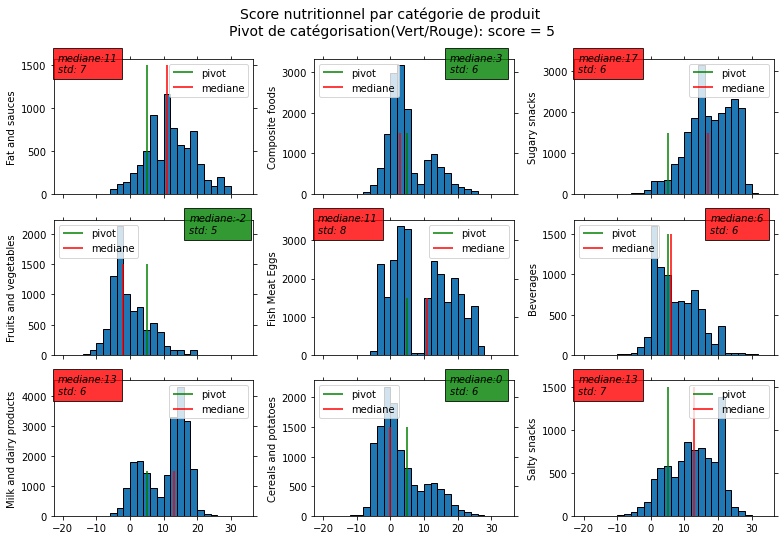

In [7]:
tPlot, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(11,7))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    t = categ_prod[i].value_counts(sort=True)
    t.sort_index(inplace=True)
    hist = list(t)
    bins = list(t.index)
    
    ax.tick_params(labelcolor='black', top='off', bottom='on', left='on', right='off')
    ax.set_ylabel(label_prod[i], fontsize = 10)
    ax.hist(categ_prod[i], bins=range(-20,36,2), edgecolor = 'k')
    ax.vlines(x=5,ymin=0,ymax=1500,color='green',label='pivot')

    mediane = int(categ_prod[i].median())
    std = int(categ_prod[i].std())
    #skewness = round(categ_prod[i].skew(),3)
    #kurtosis = round(categ_prod[i].kurtosis(),3)

    ax.vlines(x=mediane,ymin=0,ymax=1500,color='red',label="mediane")
    
    
    color = 'green' if mediane <= 5 else 'red'

    if mediane < 11:
        #ax.text(0.68, 0.9, 'mediane:' + str(mediane) + '\nskewness: ' + str(skewness) + '\nkurtosis: ' + str(kurtosis), style='italic',
        ax.text(0.68, 0.9, 'mediane:' + str(mediane) + '\nstd: ' + str(std), style='italic',
        #ax.text(0.68, 0.9, 'mediane:{}'.format(int(categ_prod[i].median())), style='italic',
        transform=ax.transAxes, fontsize = 10,
                bbox={'facecolor':color, 'alpha':0.8, 'pad':5})
        ax.legend(loc="upper left")
    else:
        #ax.text(0.02, 0.9, 'mediane:' + str(mediane) + '\nskewness: ' + str(skewness) + '\nkurtosis: ' + str(kurtosis), style='italic',
        ax.text(0.02, 0.9, 'mediane:' + str(mediane) + '\nstd: ' + str(std), style='italic',
        #ax.text(0.02, 0.9, 'mediane:{}'.format(int(categ_prod[i].median())), style='italic',
        transform=ax.transAxes, fontsize = 10,
                bbox={'facecolor':'red', 'alpha':0.8, 'pad':5})
        ax.legend(loc="upper right")
           
    i += 1

tPlot.text(0.5, 1.01, 'Score nutritionnel par groupe de produit \nPivot de catégorisation(Vert/Rouge): score = 5', ha='center', fontsize = 14)
plt.tight_layout()

<p>La forme des distributions est plutôt de type modale à multimodale, on ne décèle pas de distribution s'approchant d'une distribution normale.</p>
<p>Le tableau ci-dessous détaille l'analyse pour chaque groupe.</p>
<p>La description ne prend pas en considération les indicateurs de skewness et kurtosis qui s'appliquent à des distributions normales.</p>
<table>
    <tr>
        <td bgcolor="blue">Catégorie</td>
        <td bgcolor="blue">Médiane</td>   
        <td bgcolor="blue">Définition de la distribution</td>   
        <td bgcolor="blue">Description de la distribution (médiane/std)</td>            
        <td bgcolor="blue">Description de forme par rapport à la valeur pivot</td>   
        <td bgcolor="blue">Queue gauche</td>   
        <td bgcolor="blue">Queue droite</td>           
        <td bgcolor="blue">Commentaires de forme</td>   
        <td bgcolor="blue">Conclusions</td>
    </tr>
    <tr>
        <td>Fats and sauces</td>
        <td>11</td>
        <td>Distribution multimodale (3 modes)</td>
        <td>Forme continue et homogène de part et d'autre : cette catégorie couvre une plage de valeurs de score nutritionnel importante essentiellement dans des valeurs élevées (ie mauvais score)</td>
        <td>Forme asymétrique décentrée sur la droite</td>
        <td>Décroissement fort</td>
        <td>Etalement continu</td>
        <td>Les produits de cette catégorie présentent majoritairement un mauvais score nutritionnel, avec pour certains des valeurs très mauvaises. Il peut arriver que d'autres n'aient pas un mauvais score, cela traduit certainement des variations de qualité dans l'appellation "Matières grasses"</td>
        <td>Dans l'optique d'obtenir un repas ayant un bon score nutritionnel il est préférable de limiter voire d'éviter les produits de cette catégorie</td>
    </tr>
    <tr>
        <td>Composite foods</td>
        <td>5</td>
        <td>Distribution bimodale</td>
        <td>La médiane est confondue avec le pivot. La distribution présente un groupe recentré à gauche ce qui indique que certains produits de la catégorie ont de bons scores. Par contre à droite la distribution est plus étalée ce qui est corroboré par la valeur d'écart type qui est importante. Les produits de cette partie de la distribution peuvent même avoir de très mauvais score.</td>
        <td>Forme pseudo symétrique</td>
        <td>Décroissement fort</td>
        <td>Etalement quasi continu</td>
        <td>Cette catégorie présente de façon égale une part de produits ayant un bon score nutritionnel, tout comme un mauvais.</td>
        <td>En théorie il ne serait pas nécessairement déconseillé d'intégrer les produits de cette catégorie dans un repas, mais il faut être vigilant sur leur composition pour s'assurer de leur impact sur la qualité nutritionnelle du repas</td>
    </tr>
    <tr>
        <td>Sugary snacks</td>
        <td>18</td>
        <td>Distribution bimodale</td>
        <td>La forme de la distribution par rapport à la médiane est un peu complexe. La partie à gauche présente une valeur exceptionnelle. Hormis celle-ci la partie gauche est de forme décroissante ce qui indique qu'on retrouvera peu de produits avec un bon score nutritionnel. La partie droite est concentrée et homogène, ce qui montre que la majeure partie des produits de la catégorie présente un mauvais score nutritionnel. </td>
        <td>Forme asymétrique excentrée à droite</td>
        <td>Queue gauche quasi inexistante</td>        
        <td>Queue droite très concentrée puis étalée jusqu'aux valeurs élevées de score nutritionnel</td>
        <td>Très clairement les produits de cette catégorie ont un très mauvais score nutritionnel. A noter toutefois la présence marginal de certains produits pouvant avoir un bon score</td>
        <td>On peut aisément conclure que les produits de cette catégorie sont absolument à éviter dans le cadre d'un repas où l'on vise d'avoir un bon score nutritionnel </td>
    </tr>
    <tr>
        <td>Fruits and vegetables</td>
        <td>-4</td>
        <td>Distribution modale</td>
        <td>La distribution est très recentrée sur la valeur médiane, avec toutefois une queue droite qui s'étale légèrement, tout en restant sous la valeur pivot. Clairement les produits de cette catégorie présentent un excellent score nutritionnel. </td>
        <td>Excentrée à gauche</td>
        <td>Très recentrée sur la valeur médiane</td>        
        <td>Quasi inexistante</td>
        <td>On peut considérer que tous les produits de la catégorie ont un bon score nutritionnel</td>
        <td>Les produits de cette catégorie peuvent être intégrés dans un repas sans craindre de faire chuter le score nutritionnel global. </td>
    </tr>
    <tr>
        <td>Fish Meat Eggs</td>
        <td>5</td>
        <td>Distribution multimodale (5 modes)</td>
        <td>La médiane est confondu avec la valeur pivot. Cependant l'écart type nous alerte déjà sur le fait que la distribution n'est pas homogène. On le constate avec sa forme qui est scindée bien distinctement. La partie gauche est bien regroupée sur une plage courte de valeurs de score nutritionnels ce qui signifie que les produits dans cette partie de la distribution sont nutritionnellement bons. A contrario la partie droite présente une rupture avec une forme étalée et homogène, qui montre un saut dans les valeurs de score nutritionnel élevées. Cela indique probablement une disparité de nature de produit</td>
        <td>Forme complexe présentant une rupture</td>
        <td>Homogène</td>        
        <td>Rupture puis étalement homogène</td>
        <td>La catégorie n'est pas homogène. Dans la même catégorie on retrouve des produits dont le score nutritionnel est soit très bon soit mauvais. </td>
        <td>Cette catégorie montre qu'il faudrait affiner la granularité d'analyse. En l'état il est difficile d'apporter une conclusion. C'est un pallier dans notre analyse, nous affinerons au point suivant</td>
    </tr>
    <tr>
        <td>Beverages</td>
        <td>11</td>
        <td>Distribution multimodale (3 modes)</td>
        <td>Forme plutôt uniformément étalée symétriquement par rapport à la médiane. Les deux queues couvrent des plages de valeurs assez larges. L'écart type étant assez élevé, on peut penser que cette catégorie englobe un ensemble assez disparate de produits </td>
        <td>Forme aplatie évasée couvrant une large plage de valeurs de score nutritionnel</td>
        <td>Courte avec une valeur exceptionnelle</td>
        <td>Homogène très étalée</td>  
        <td>La catégorie couvre des produits qui présentent des valeurs très disparates. Certains ont de bons score, mais on retrouve à l'opposé d'autres qui ont de mauvaises performances</td>
        <td>Là encore nous pouvons conclure que la granularité d'analyse n'est pas suffisante pour établir un conseil autour des produits de cette catégorie.</td>
    </tr>
    <tr>
        <td>Milk and dairy products</td>
        <td>13</td>
        <td>Distribution bimodale</td>
        <td>La forme générale de la distribution montre qu'il y a deux ensembles de produits avec une rupture dans les valeurs de score nutritionnel. Le groupement à gauche présente une densification à partir d'une valeur beaucoup plus basse que la médiane, tandis que le groupement à droite est continu et homogène dans les valeurs élevées. Ce constat est corroboré par la valeur d'écart type qui est élevée</td>
        <td>Forme complexe avec deux groupements distincts</td>
        <td>N/A</td>        
        <td>N/A</td>
        <td>Les produits de la catégorie ne présentent pas tous les mêmes caractéristiques nutritionnelles. Il s'agit d'un ensemble non homogène pour lequel il est difficile de tirer des généralités sur ses qualités nutritionnelles.</td>
        <td>A nouveau nous devons affiner la granularité d'analyse.</td>
    </tr>
    <tr>
        <td>Cereals and potatoes</td>
        <td>0</td>
        <td>Distribution modale</td>
        <td>La forme est asymétrique avec une queue droite progressivement dégressive vers des valeurs élevées. </td>
        <td>La forme est asymétrique avec une répartition élevé de la distribution à gauche de la valeur pivot.</td>
        <td>Homogène avec une valeur élevée</td>        
        <td>Etalée progressivement dégressive</td>
        <td>La médiane étant très inférieure à la valeur pivot on peut comprendre que l'essentiel de ces produits présente de bons à très bons scores. Mais parmi les produits de la catégorie on en retrouve qui présentent de mauvais score, ce qui tend à montrer qu'il est impossible de généraliser a priori sur ces produits en partant uniquement de leur catégorie.</td>
        <td>De nouveau la granularité d'analyse n'est pas suffisante pour établir des recommandations sur cette catégorie.</td>
    </tr>
    <tr>
        <td>Salty snacks</td>
        <td>9</td>
        <td>Distribution multimodale (3 modes)</td>
        <td>Forme étalée aplatie, équi-répartie de part et d'autre de la valeur médiane. L'écart type étant proportionnellement élevé on a une distribution peu homogène en termes de score nutritionnel </td>
        <td>Forme légèrement asymétrique</td>
        <td>Aplatie légèrement dégressive</td>        
        <td>Aplatie légèrement dégressive</td>
        <td>Cette catégorie regroupe peu de produits par rapport aux autres. Sa distribution en termes de score nutritionnel étant disparate, il semble difficile d'apporter des recommandations générales à leur sujet.</td>
        <td>Il est probable que d'affiner la granularité de l'analyse permettra de mieux classifier ces produits pour établir de meilleurs recommandations nutritionnelles </td>
    </tr>
</table>
<br>
<p>Globalement il ressort de cette analyse qu'il serait plus intéressant d'étudier la dépendance du score nutritionnel au facteur "groupe" en partant d'une feature facteur plus détaillée. On souligne que les distributions ne suivent pas une loi normale, ce qui va contraindre les outils d'analyse statistiques que l'on pourra utiliser.</p>

<b style="background-color:tomato;font-size:14px;">5 ANALYSE EXPLICATIVE<b>
    <a id="expl"></a> 

<b style="background-color:tomato;font-size:12px;">5.1 Influence du facteur bio <b>
    <a id="bio"></a> 

<p>Dans l'idée qu'un produit bio pourrait être meilleur et que cela s'en ressente sur le score nutritionnel on propose de faire une analyse de dépendance du score nutritionnel avec le facteur bio des produits.</p>
<p>Pour cela on crée un indicateur 'bio' qui est déterminé à partir de la feature labels_tags qui mentionne si le produit est "bio" ou "organic". </p>
<p>L'indicateur qualitatif résultant aura deux valeurs :</p>
<p>0 : n'est pas bio</p>
<p>1 : est bio</p>
<p>Sous réserve que les hypothèses fondamentales soient remplies, on effectuera alors une ANOVA bivariée se basant sur un test de Fischer (calcul de la F-value) qui permet de comparer la variance inter-échantillon à la variance intra-échantillon. Ici l'hypothèse nulle H0 est l'égalité des moyennes intergroupe et intragroupe, signifiant alors une dépendance du score nutritionnel avec le facteur bio.</p>
<p>Dans le cas où les hypothèses fondamentales ne seraient pas remplies on effectuera alors plutôt une variante non paramétrique de l'analyse de variance (anova de Friedman).</p>
<p>Dans ce cas d'étude la variable dépendante est le nutriscore, et le facteur explicatif est l'indicateur bio.</p>
<p>On espère démontrer la dépendance de ces deux variables en montrant que l'hypothèse nulle d'égalité des moyennes peut être rejetée. </p>

<p><b>Hypothèses fondamentales à vérifier :</b></p>
<p>Normalité de la distribution : </p>
<p>- on suppose, sous l'hypothèse nulle, que les échantillons sont issus d'une même population et suivent une loi normale. Il est donc nécessaire de vérifier la normalité des distributions. Pour cela on utilisera le test de Shapiro.</p>
<p>- on vérifiera l'homoscédasticité (homogénéité des variances) par un test de Levene (plus robuste à une distribution non normale). </p>    

In [53]:
def bio_indicator(row):    
    v = row['labels_tags']
    new_val=0
    if ("organic" in v or "bio" in v):
        new_val=1
        
    return new_val    


In [54]:
#Contruction du subset d'analyse
subset = data[data.labels_tags.notnull()]
subset = subset[subset.nutriscore_score.notnull()]
subset['bio'] = subset.apply (lambda row: bio_indicator(row), axis=1)
subset[['brands_tags','labels_tags','nutriscore_score','bio','product_name','pnns_groups_3']].head()

,brands_tags,labels_tags,nutriscore_score,bio,product_name,pnns_groups_3
0,courte-paille,fr:delois-france,18.0,0,moutarde au moût de raisin,Dressings and sauces
21,NaN,en:palm-oil-free,2.0,0,Pâte a tartiner,Sweets
26,comme-j-aime,"fr:viande-francaise,en:made-in-france",0.0,0,Blanquette de Volaille et son Riz,One-dish meals
31,comme-j-aime,en:green-dot,2.0,0,Entremets Crème Brulée,Dairy desserts
36,kazidomi,"en:organic,en:eu-organic,en:eu-non-eu-agricult...",7.0,1,Pommes séchées,Dried fruits


On vérifie les hypothèses fondamentales :

In [55]:
p_value = stats.shapiro(subset['nutriscore_score'].iloc [0:5000, ])[1]
if p_value < 0.05:
    print('p = ' + str(p_value) + " --> H0 rejetée: La distribution ne suit pas une loi normale")
else:
    print('p = ' + str(p_value) + " --> H0 non rejetée: La distribution suit une loi normale")

p = 9.637295578004309e-33 --> H0 rejetée: La distribution ne suit pas une loi normale


In [56]:
levene=stats.levene(*[grp for idx, grp in subset[['nutriscore_score','bio']].iteritems()])
if levene[1] < 0.05:
    print('p = ' + str(levene[1]) + " --> H0 rejetée: l'égalité de variance n'est pas vérifiée")
else:
    print('p = ' + str(levene[1]) + " --> H0 non rejetée: l'égalité de variance est vérifiée")    
    

p = 0.0 --> H0 rejetée: l'égalité de variance n'est pas vérifiée


<p>Les hypothèses nulles des deux hypothèses fondamentales sont rejetées, par conséquent nous ne pouvons pas mener une ANOVA paramétrique bivariée standard.</p>
<p>Nous allons donc suivre une ANOVA non paramétrique de Friedman</p>

In [61]:
details=[]
details.append(['Feature','p-value','Dépendance'])

for feat in scoring_features:
    fried = stats.friedmanchisquare(*[grp for idx, grp in subset[['nutriscore_score',feat,'bio']].iteritems()])
    if fried[1] < 0.05:
        details.append([feat,str(fried[1]),' Infirmée'])
    else:    
        details.append([feat,str(fried[1]),' Confirmée'])
        
print(tabulate(details))              

---------------------------  -------  ----------
Feature                      p-value  Dépendance
energy-kcal_100g             0.0      Infirmée
saturated-fat_100g           0.0      Infirmée
salt_100g                    0.0      Infirmée
sugars_100g                  0.0      Infirmée
fiber_100g                   0.0      Infirmée
proteins_100g                0.0      Infirmée
fruits-vegetables-nuts_100g  0.0      Infirmée
---------------------------  -------  ----------


<p>L'hypothèse H0 de l'ANOVA non paramétrique de Friedman est que les données des sous-ensembles suivent une même distribution. </p>
<p>La valeur de la p-value étant 0, on rejette H0 : le facteur "bio" n'est pas influent sur le score nutritionnel, quelle que soit la feature de scoring étudiée. </p>
<p>Pour confirmer cette conclusion on complète avec une autre ANOVA non paramétrique, celle de Kruskal, dont l'hypothèse H0 est l'égalité intergroupe de la médiane.</p>

In [62]:
stat, p = kruskal(*[grp for idx, grp in subset[['nutriscore_score','bio']].iteritems()])

print('stat = ' + str(stat) + ' - p-value = ' + str(p))

stat = 31353.81608145026 - p-value = 0.0


<p>L'hypothèse H0 de l'ANOVA non paramétrique de Kruskal est rejetée, par conséquent on conlut à nouveau qu'il n'y a pas d'égalité de médiane intergroupe, ce qui nous permet de conclure que le facteur bio n'est pas un facteur influent sur le score nutritionnel. </p>

<b style="background-color:tomato;font-size:12px;">5.2 Influence du facteur sous groupe sur le nutriscore<b>
    <a id="facteur_groupe"></a> 

<p>On se propose d'effectuer une anova bivariée paramétrique standard sans tenir compte des hypothèses fondamentales.</p>
<p> L'idée est d'évaluer la robustesse de la méthode et voir s'il est possible d'obtenir de l'information sur le cas étudié : influence du facteur sous groupe sur le nutriscore.</p>
<p>On pose l'hypothèse nulle H0 = il n'y a pas de différence de moyenne entre les groupes, et l'hypothèse H1 = le facteur groupe influe sur le nutriscore</p>
<p>(NB: L'anova est menée à titre d'exemple d'implémentation, nous n'utiliserons pas les résultats obtenus et n'établirons aucune conclusion)</p>

DFbetween: 36
DFwithin: 59938
DFtotal: 59974


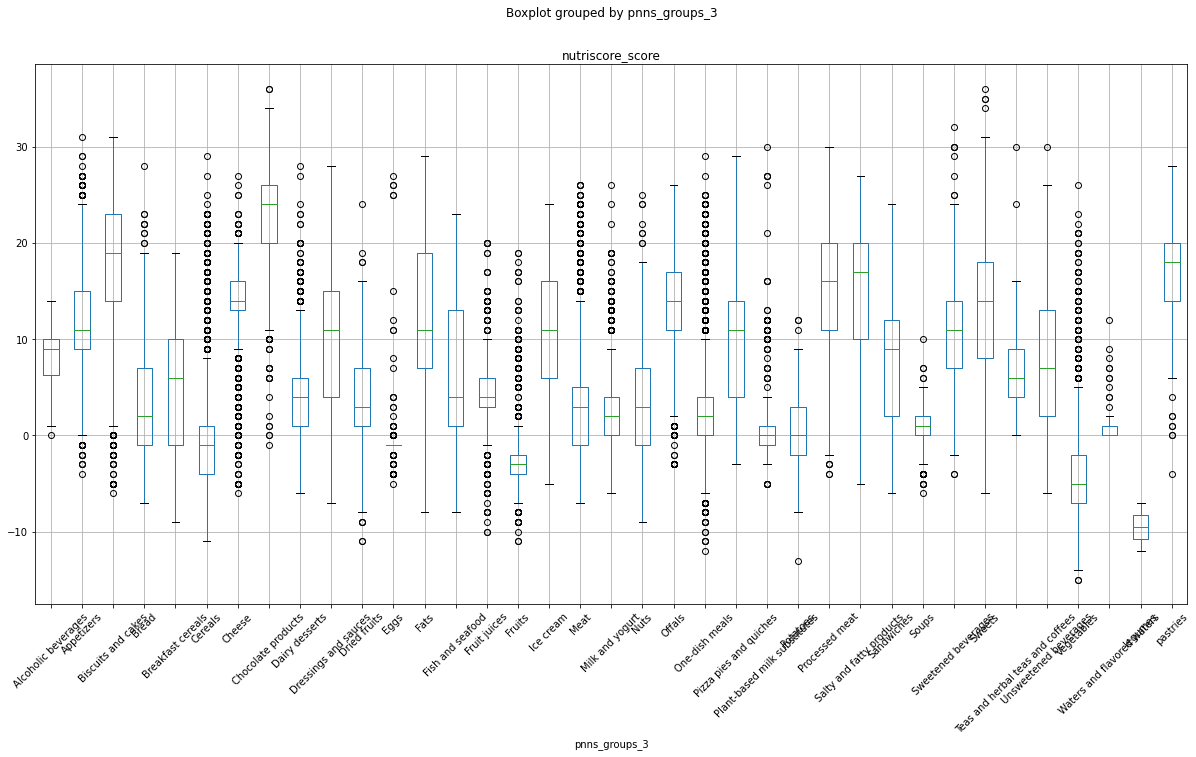

In [63]:
#Create a boxplot
subset.boxplot('nutriscore_score', by='pnns_groups_3', figsize=(20, 10),rot=45)

ctrl = subset['nutriscore_score'][subset.pnns_groups_3 == 'ctrl']

grps = pd.unique(subset.pnns_groups_3.values)
d_data = {grp:subset['nutriscore_score'][subset.pnns_groups_3 == grp] 
    for grp in pd.unique(subset.pnns_groups_3.values)}

k = len(pd.unique(subset.pnns_groups_3))  # number of conditions
N = len(subset.values)  # nb total of participants
n = subset.groupby('pnns_groups_3').size()[0] #nb of Participants in each condition
#Degree of freedom (DF)
DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

print('DFbetween: ' + str(DFbetween))
print('DFwithin: ' + str(DFwithin))
print('DFtotal: ' + str(DFtotal))


In [136]:
F, p = stats.f_oneway(*[d_data[key] for key,values in d_data.items()] )
print('F-value = ' + str(F),' / p-value = ' + str(p))

F-value = 2160.6302948413854  / p-value = 0.0


<p>A ce stade on a une F-value >> 1 et une p-value à 0 ce qui permet de rejeter l'hypothèse H0 d'égalité des moyennes. </p>
<p>L'hypothèse H1 doit encore être validée par la mise en corrélation des deux variables. Pour établir cela on effectue le calcul de eta2 qui est le rapport de correlation entre le facteur explicatif et la variable étudiée. </p>

In [133]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta2 = eta_squared(subset["pnns_groups_3"],subset["nutriscore_score"])
print('eta squarred = ' + str(eta2))

eta squarred = 0.5647858013734434


<p>On obtient un résultat proche de 0.56, ce qui permet de valider l'hypothèse H1 : la dépendance étudiée du facteur sous groupe avec la variable nutriscore est significative.<p></p>
Une analyse complémentaire (analyse post hoc qui compare 2 à 2 les individus de la distribution, ici on utilise le test de Tukey) va permettre de ressortir les groupes qui diffèrent significativement les uns des autres. Le nombre de sous groupes étant de 37 la liste résultante est un peu longue, c'est pourquoi nous l'illustrons ensuite par un graphique plus synthétique. </p>

In [ ]:
import statsmodels.stats.multicomp as mc
comp = mc.MultiComparison(subset["nutriscore_score"],subset["pnns_groups_3"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

In [ ]:
post_hoc_res.plot_simultaneous(ylabel= "Sous groupes", xlabel= "Score Difference")

<b style="background-color:tomato;font-size:12px;">5.3 Analyse des features de scoring par sous groupes <b>
    <a id="feature_scoring"></a> 

<p>L'analyse précédente (NON VALIDANTE) amène notre reflexion à étudier la répartition des features de scoring par sous groupe dans l'idée d'avoir une représentation de l'expression de la feature par rapport aux sous-groupes afin :</p> 
<p>1. d'évaluer comment la feature est représentée dans chaque sous-groupe</p>
<p>2. de diagnostiquer comment chaque sous-goupe pèse sur la feature de scoring, et en fonction de l'effet positif/négatif sur le nutriscore (cf notebook Discover) et de l'IQR (interquartile range) on peut définir un indice de qualité sur une base de quatre niveaux : </p>
<table>
    <tr>
        <td align="center" bgcolor="green">IQR(Borne inférieure)</td>
        <td align="center" bgcolor="green">IQR(Borne supérieure)</td>
        <td align="center" bgcolor="green">Impact</td>
        <td align="center" bgcolor="green">Indice d'impact</td>        
    </tr>
    <tr>
        <td>0</td>
        <td>moyenne - std</td>
        <td>Faible</td>
        <td>1</td>
    </tr>
    <tr>
        <td>0</td>
        <td>moyenne</td>
        <td>Faible à modéré</td>
        <td>2</td>
    </tr>
    <tr>
        <td>moyenne - std</td>
        <td>moyenne</td>
        <td>Modéré</td>
        <td>3</td>
    </tr>
    <tr>
        <td>moyenne - std</td>
        <td>moyenne + std</td>
        <td>Modéré à marqué</td>
        <td>5</td>
    </tr>
    <tr>
        <td>moyenne</td>
        <td>moyenne + std</td>
        <td>Marqué</td>
        <td>7</td>
    </tr>
    <tr>
        <td>moyenne + std</td>
        <td>-</td>
        <td>Très marqué</td>
        <td>10</td>
    </tr>
</table>
<p>En synthèse on pourra alors établir une matrice classant ces sous-groupes par feature et donnant un synopsys des sous-groupes à risque ou au contraire à privilégier pour d'une part comprendre le score nutritionnel d'un repas et d'autre part permettre de proposer des alternatives pour améliorer ce score nutritionnel et aller également dans le sens des recommandation du ministère.</p>

In [242]:
def plotSynopsys(synopsys):
    # Prepare table
    columns = ('Sous groupe', 'energy-kcal_100g', 'saturated-fat_100g', 'salt_100g', 'sugars_100g','fiber_100g','proteins_100g','fruits-vegetables-nuts_100g')
    rows = ["A", "B","C","D","E","F","G","H"]

    cell_text=[]
    colors=[]
    dummy_cell_text=[]
    color=[]

    for k in sorted(data['pnns_groups_3'].unique()):
        dummy_cell_text=[]
        color=[]
        dummy_cell_text.append(k)
        color.append('w')
        for feat in scoring_features:
            dummy_cell_text.append("")
            if synopsys[feat][k] == '-10':
                color_ref = '#FB1F05'
            if synopsys[feat][k] == '-7':
                color_ref = '#E9402C'
            if synopsys[feat][k] == '-5':
                color_ref = '#DC5343'
            if synopsys[feat][k] == '-3':
                color_ref = '#E56A5C'
            if synopsys[feat][k] == '-2':
                color_ref = '#DF8177'
            if synopsys[feat][k] == '-1':
                color_ref = '#E49289'
            if synopsys[feat][k] == 'n/a':
                color_ref = '#F6C5C0'
            if synopsys[feat][k] == '10':
                color_ref = '#0EA309'
            if synopsys[feat][k] == '7':
                color_ref = '#42C13E'
            if synopsys[feat][k] == '5':
                color_ref = '#59D355'
            if synopsys[feat][k] == '3':
                color_ref = '#71E06E'
            if synopsys[feat][k] == '2':
                color_ref = '#8CEB8A'
            if synopsys[feat][k] == '1':
                color_ref = '#B4F9B2'
            color.append(color_ref)
            
        cell_text.append(dummy_cell_text)
        colors.append(color)
        
    # Add a table at the bottom of the axes
    fig, ax = plt.subplots(figsize=(20,16))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,cellColours=colors,colLabels=columns,loc='top')

    plt.show()                
            


In [244]:
synopsys = dict.fromkeys([ 'energy-kcal_100g', 'saturated-fat_100g','salt_100g',
                            'sugars_100g','fiber_100g','proteins_100g','fruits-vegetables-nuts_100g'])
def plotFeatureBySubGroups(feature,way):
    feat_mean = data[feature].mean()
    feat_std = data[feature].std()
    low_threshold = feat_mean - feat_std
    high_threshold = feat_mean + feat_std

    fig, ax = plt.subplots(figsize=(20,16))
    plt.suptitle('')
    data.boxplot(column=[feature], by='pnns_groups_3', ax=ax,rot=45)
    ax.axhline(y=feat_mean, color='green', linestyle='--',label='moyenne')
    ax.axhline(y=feat_mean + feat_std, color='r', linestyle='--',label='moyenne+std')
    ax.axhline(y=feat_mean - feat_std, color='orange', linestyle='--',label='moyenne-std')
    plt.legend()
    
    desc=data[[feature,'pnns_groups_3']].groupby('pnns_groups_3').describe()
    
    sub_dict={}
    
    for i in desc.index:
        #print(i)
        row = desc.loc[i,:]
        #print(list(row))

        list_row=list(row)
        #print(list_row[0])

        Q1_percent=list_row[4]
        Q3_percent=list_row[6]

        if  Q1_percent < low_threshold and Q3_percent < low_threshold:
            rank = '-1'
            if way == 'positive':
                rank='1'
        if  Q1_percent < low_threshold and Q3_percent < feat_mean:
            rank = '-2'
            if way == 'positive':
                rank='2'
        if  Q1_percent < low_threshold and Q3_percent < high_threshold:
            rank = 'n/a'
        if  Q1_percent < low_threshold and Q3_percent > high_threshold:
            rank = 'n/a'
        if  Q1_percent > low_threshold and Q3_percent < feat_mean:
            rank = '-3'
            if way == 'positive':
                rank='3'
        if  Q1_percent > low_threshold and Q3_percent < high_threshold:
            rank = '-3'
            if way == 'positive':
                rank='3'
        if  Q1_percent > low_threshold and Q3_percent > high_threshold:
            rank = '-5'
            if way == 'positive':
                rank='5'
        if  Q1_percent > feat_mean and Q3_percent < high_threshold:
            rank = '-7'
            if way == 'positive':
                rank='7'
        if  Q1_percent > feat_mean and Q3_percent > high_threshold:
            rank = '7'
            if way == 'positive':
                rank='-7'
        if  Q1_percent > high_threshold:
            rank = '-10'
            if way == 'positive':
                rank='10'
        sub_dict[i]=rank
        #print(i + ': ' + rank)      
        synopsys[feature]=sub_dict
    
    #print(synopsys)

<b style="background-color:tomato;font-size:10px;">5.3.1 Energie <b>
    <a id="feature_scoring_energy"></a> 

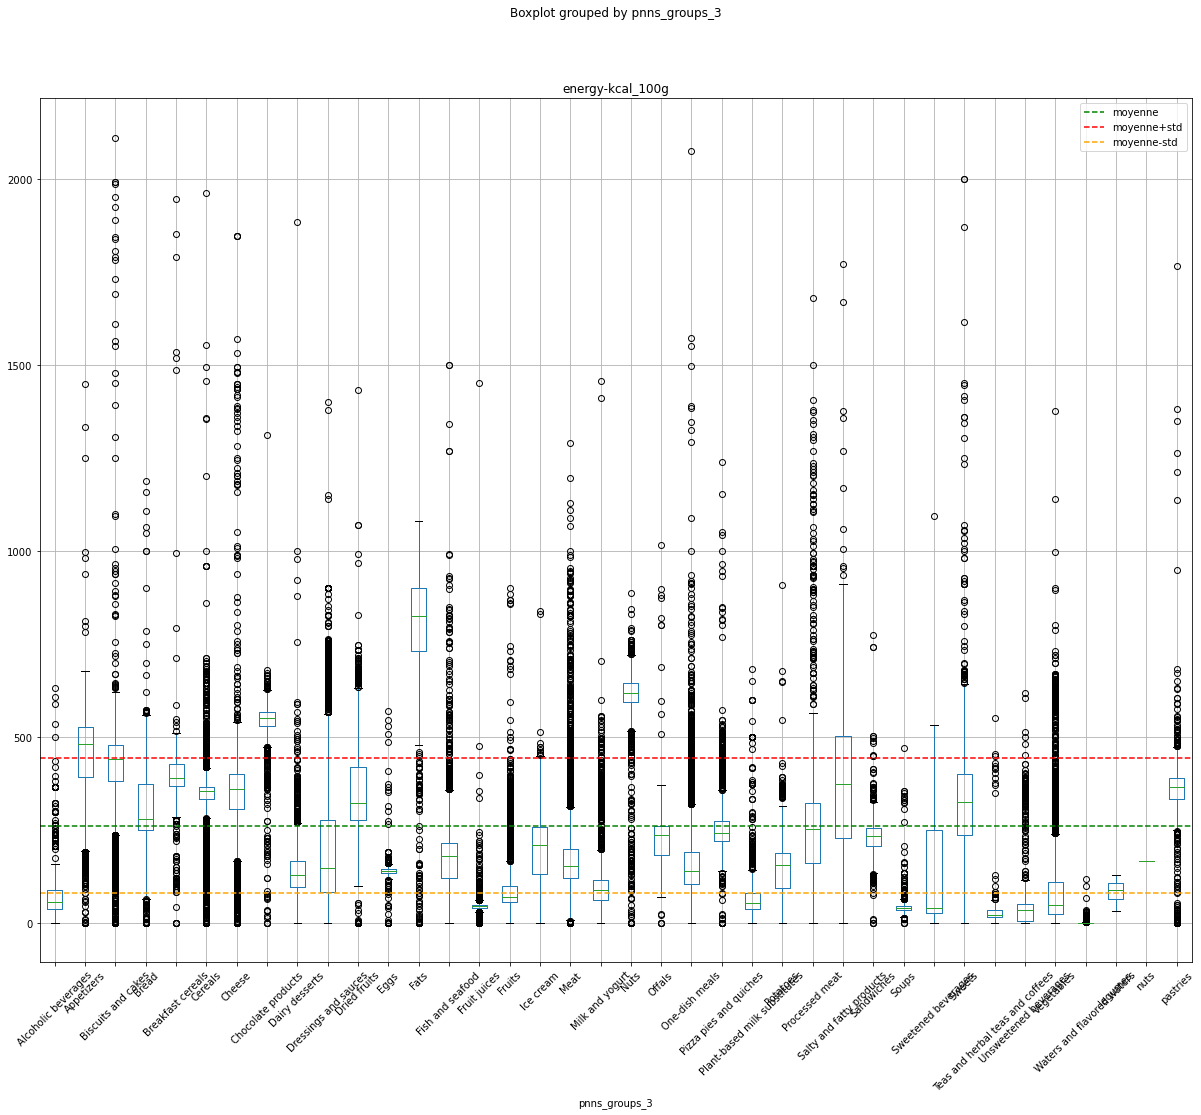

In [245]:
plotFeatureBySubGroups('energy-kcal_100g','negative')

<p>La représentation de la feature energy-kcal_100g par sous-groupe présente une très grande variabilité. La valeur moyenne passe de valeurs très basses pour les Thés infusion et cafés (teas and herbal teas and coffees) ou encore Eaux et eaux parfumées (Waters and flavored waters) à élevées pour les Matières grasses (fats_100g) et les produits chocolatés (Chocolate products).</p>
<p>Certains sous-groupes présentent une distribution étalée, partant de valeurs basses même proches de 0 mais pouvant atteindre des valeurs aussi élevées que les matières grasses. Parmis ces sous-groupes on note les Assaisonnements et Sauces (Dressing and sauces), les fruits secs (dried fruits), produits salés et gras (salty and fatty products) et enfin les Boissons sucrées (sweetened beverages). Les produits de ces sous-groupes présentent donc une grande variabilité et il faudrait étudier le détail de leur composition pour définir si oui ou non ils doivent faire l'objet d'une proposition d'alternative dans le cadre de l'application.</p>
<p>En conclusion la feature energy-kcal_100g permet de cerner les sous-groupes devant faire l'objet d'une attention particulière dans le cadre de l'application des préconisations du ministère : matières grasses en premier lieu, boissons sucrées, produits chocolatés en second lieu, et au cas par cas les Assaisonnements et sauces.</p>

<b style="background-color:tomato;font-size:10px;">5.3.2 Sucre <b>
    <a id="feature_scoring_sugar"></a> 

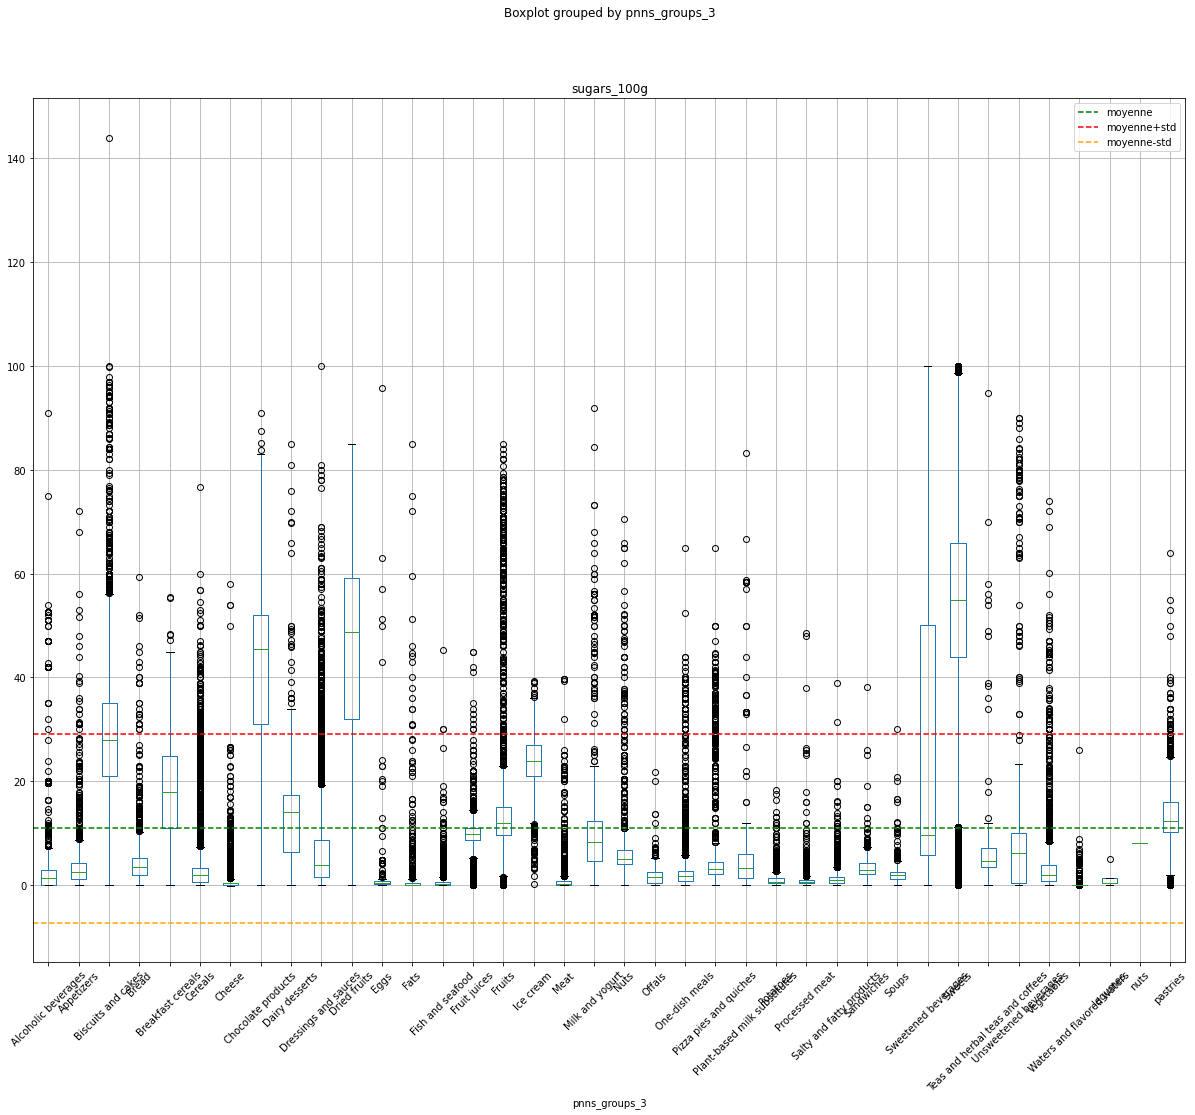

In [246]:
plotFeatureBySubGroups('sugars_100g','negative')

<p>Quate sous groupes de produit se détachent immédiatement : les biscuits et gateaux (Biscuits and cakes), les produits chocolatés (Chocolate products), les fruits secs (Dried fruits) et les boissons sucrées (Sweetened beverages). </p>
<p>Les produits de ces sous groupes présentent une distribution étalée pouvant atteindre des valeurs très élevées (100% de sucre pour certaines boissons sucrées !). Ce sont donc des produits sur lesquels il faut être vigilant sur leur composition avant de les consommer.</p>

<b style="background-color:tomato;font-size:10px;">5.3.3 Acides gras saturés <b>
    <a id="feature_scoring_saturated_fat"></a> 

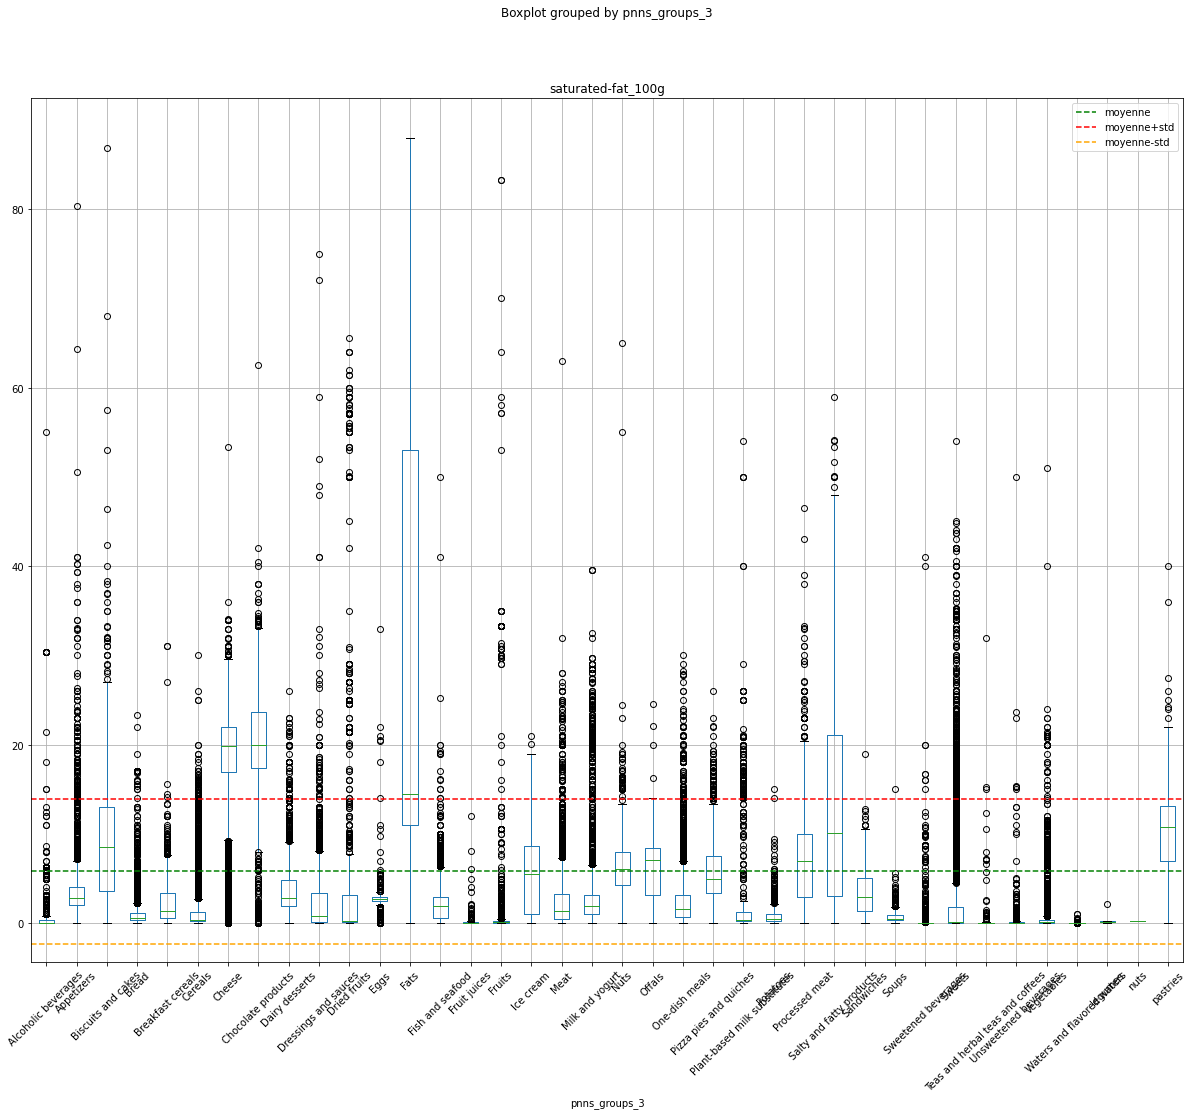

In [247]:
plotFeatureBySubGroups('saturated-fat_100g',"negative")

<p>On peut dégager des sous-groupes marqués par une distribution très centrée sur des teneurs élevées en lipides saturés (>= 20%). Sans surprise on retrouve le fromage (cheese) et les produits chocolatés (Chocolate products).</p>
<p>Le cas des matières grasses est particulier puisque par définition les produits de ce sous-goupe ne sont composés que de matières grasses (beurre, huiles, margarines)</p>
<p>A noter des valeurs très hautes (~ 30%) atteintes par certains individus des sous-groupes Biscuits et gateaux (Biscuits and cakes) et  patisseries (pastries).</p>
<p></p>

<b style="background-color:tomato;font-size:10px;">5.3.4 Sel <b>
    <a id="feature_scoring_salt"></a> 

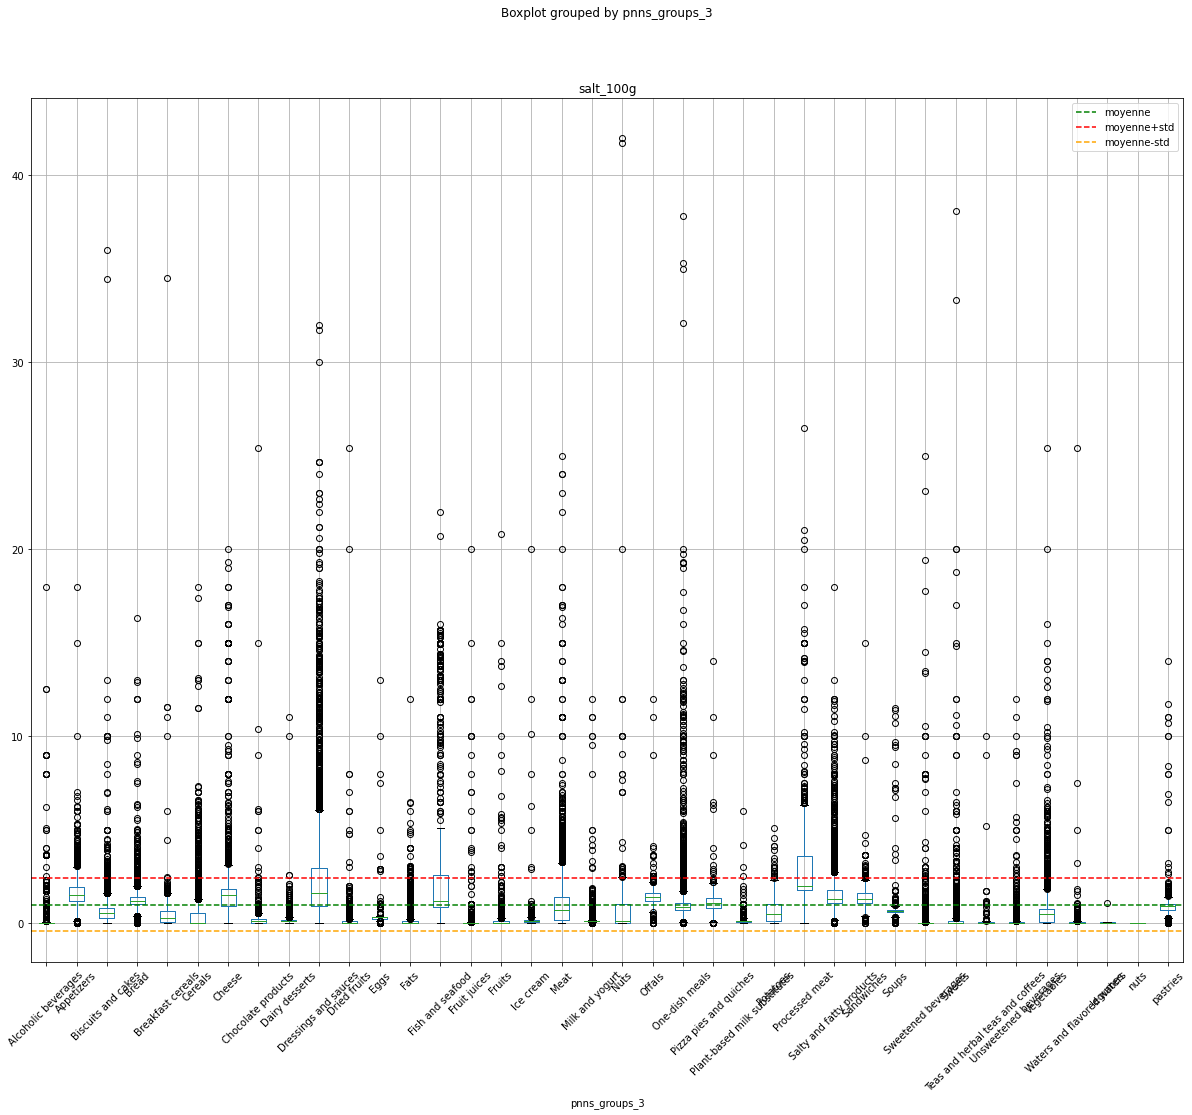

In [248]:
plotFeatureBySubGroups('salt_100g','negative')

<p>Le profil de l'expression de la feature salt_100g sur les sous groupes indique que c'est un ingrédient qui est peu présent proportionnellement, on est sur une médiane globale d'environ 2%, avec un IQR petit (la distribution est bien centrée sur la valeur médiane).</p>
<p>C'est pourquoi il est important de remonter les sous-groupes qui présentent des valeurs nettement supérieures de teneur en sel, comme c'est le cas pour les Assaisonnements et Sauces (Dressings and sauces), les poissons et crustacés (Fish and seafood), ainsi que la viande préparée (Processed meat). Ces sous groupes présentent une médiane équivalente aux autres, mais la distribution est plus étalée et les 3ème quartiles et valeurs max peuvent atteindre 2 fois la valeur médiane.</p>
<p>Là encore pour proposer des alternatives de produits équivalents dans le sous groupe il faudra tenir compte de la teneur réel en sel de l'alternative.</p>

<b style="background-color:tomato;font-size:10px;">5.3.5 Fruits, légumes, oléagineux <b>
    <a id="feature_scoring_fruits"></a> 

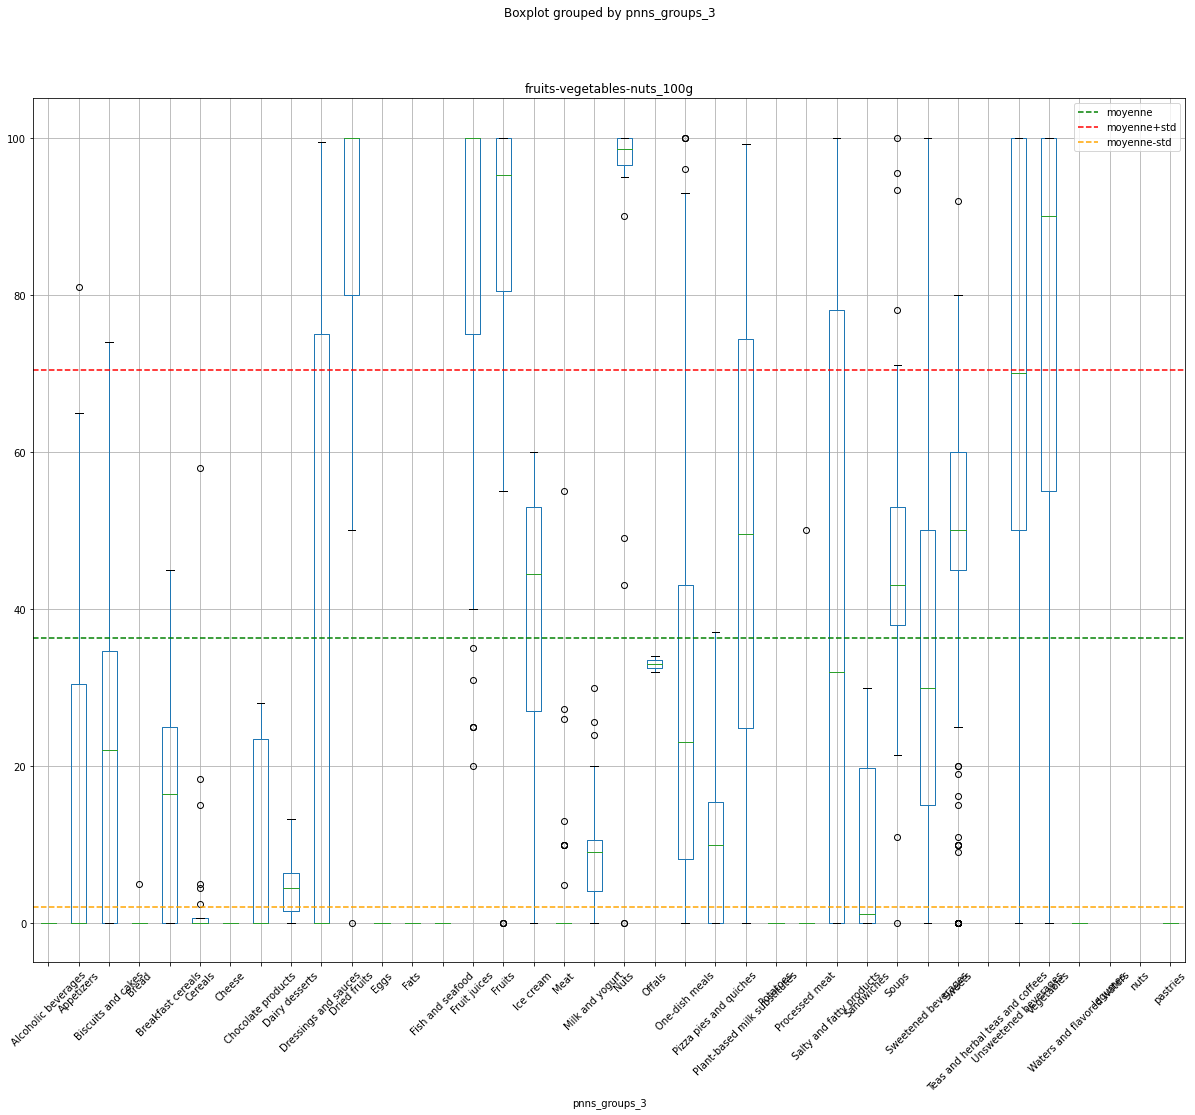

In [249]:
plotFeatureBySubGroups('fruits-vegetables-nuts_100g','positive')

<p>L'aspect générale du graphique tranche nettement avec celui des graphiques précédents.</p>
<p>On trouve de nombreux boxplots avec un IQR très large signifiant que la distribution est très étalée, certains ne présentent pas de valeur minimum distincte.</p>
<p>A l'inverse on retrouve bien la représentation des fruits légumes et noix (Dried fruits, Fruits, Nuts, Vegetables)) avec l'absence de valeur maximal qui fait que le 3ème quartile atteint la valeur maximum (100%) </p>
<p> A noter des valeurs remarquables pour les Assaisonnements et sauces (Dressings and sauces) ainsi que les Produits salés et gras (Salty and fatty products). On peut avancer l'hypothèse que ces produits intègrent en partie des ingrédients apparentés aux légumes/noix, mais que le produit fini résulte d'une transformation qui le classe dans une autre catégorie.</p>

<b style="background-color:tomato;font-size:10px;">5.3.6 Fibres <b>
    <a id="feature_scoring_fibers"></a> 

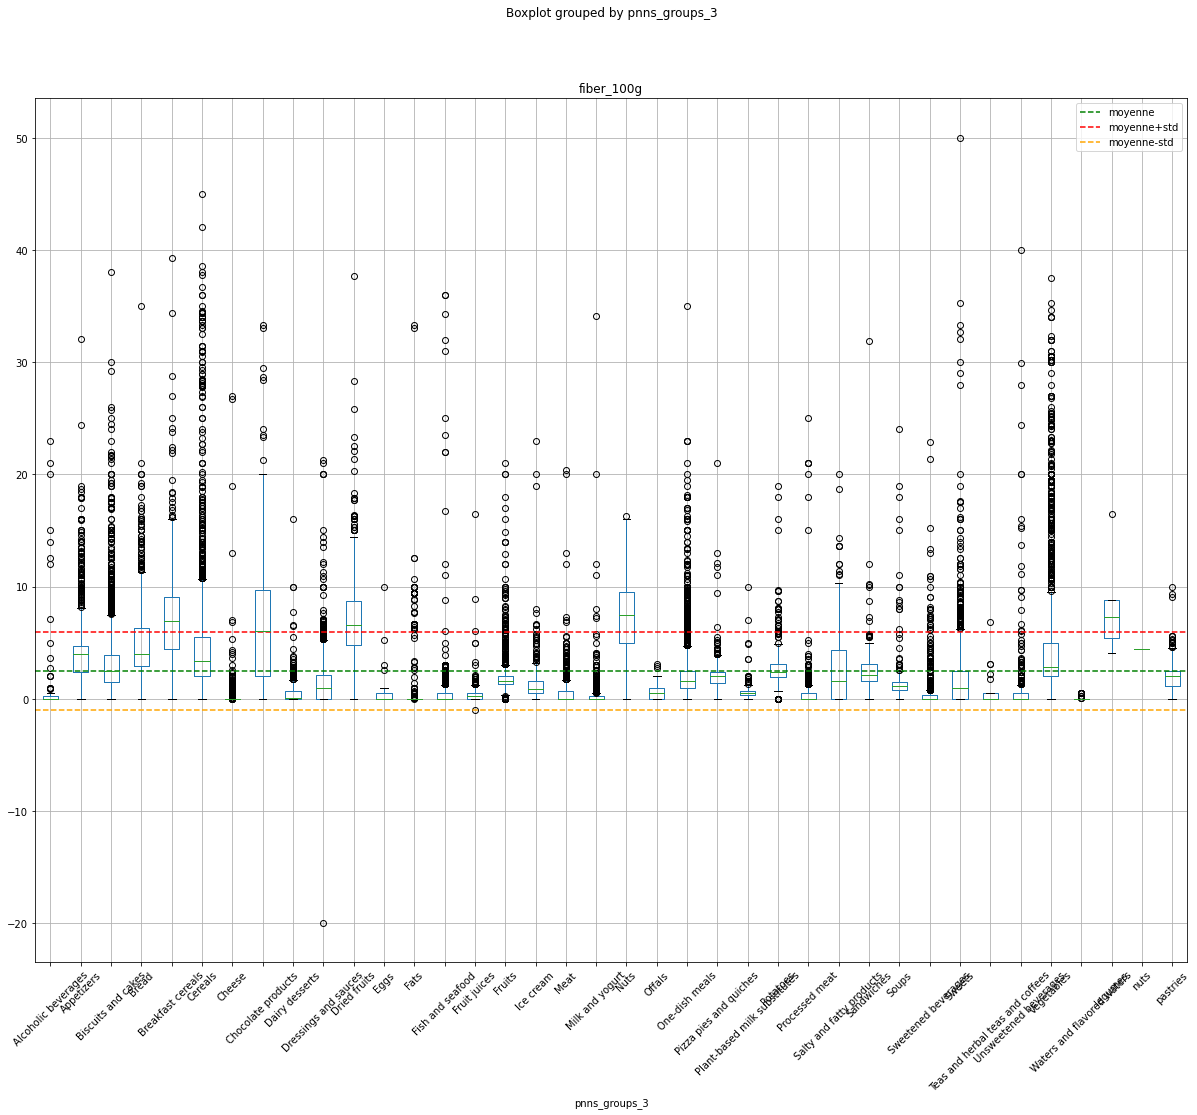

In [250]:
plotFeatureBySubGroups('fiber_100g','positive')

<p>La représentativité de la feature est assez similaire à celle du sel : les valeurs médianes sont faibles (~ 5%) et les IQR restent petits signifiant une distribution centrée sur la médiane.</p>
<p>Quelques sous groupes présentant une bonne densité de valeurs élevées de teneur en fibres se détachent : Noix (nuts), Légumes (Vegetables) et les fruits secs (Dried fruits). A noter également les produits chocolatés (Chocolate products) qui présentent une bonne teneur en fibre. A pondérer avec les autres features pour lesquels ces produits ne présentent pas de bons indicateurs.</p>

<b style="background-color:tomato;font-size:10px;">5.3.7 Protéines <b>
    <a id="feature_scoring_proteins"></a> 

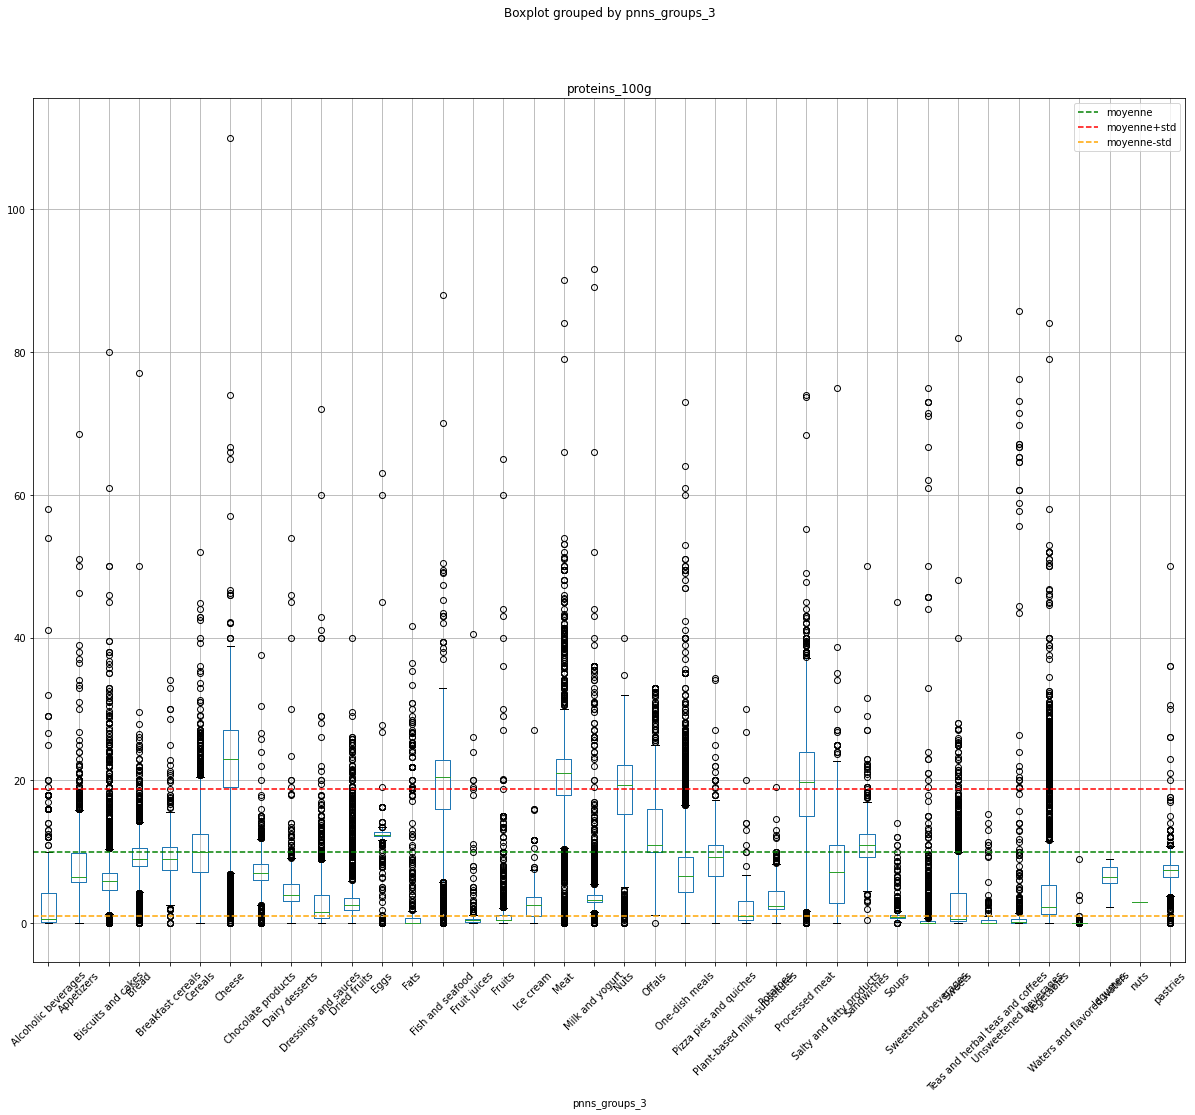

In [251]:
plotFeatureBySubGroups('proteins_100g','positive')

<p>Globalement les valeurs médianes sont assez basses, ce qui indique que les sources de protéines ne se trouvent pas facilement.</p>
<p>On les détecte principalement dans le fromage (Cheese), le poisson et les fruits de mer (Fish and seafood), la viande (Meat), les abats (offals) et la viande transformée (processed meat). Il s'agit donc plutôt de produits issus de l'agriculture.</p>
<p>Cependant on remarque que les noix (Nuts) présentent des teneurs similaires à celles du poisson (boxplot quasi identique). C'est une piste d'alternative dans le cadre de notre application visant appliquer la recommandation du ministère de réduire la consommation de viande, mais en cherchant à préserver l'équilibre des apports en nutriments, notamment en protéines.</p>

<b style="background-color:tomato;font-size:10px;">5.3.8 Synthèse <b>
    <a id="feature_scoring_synth"></a> 

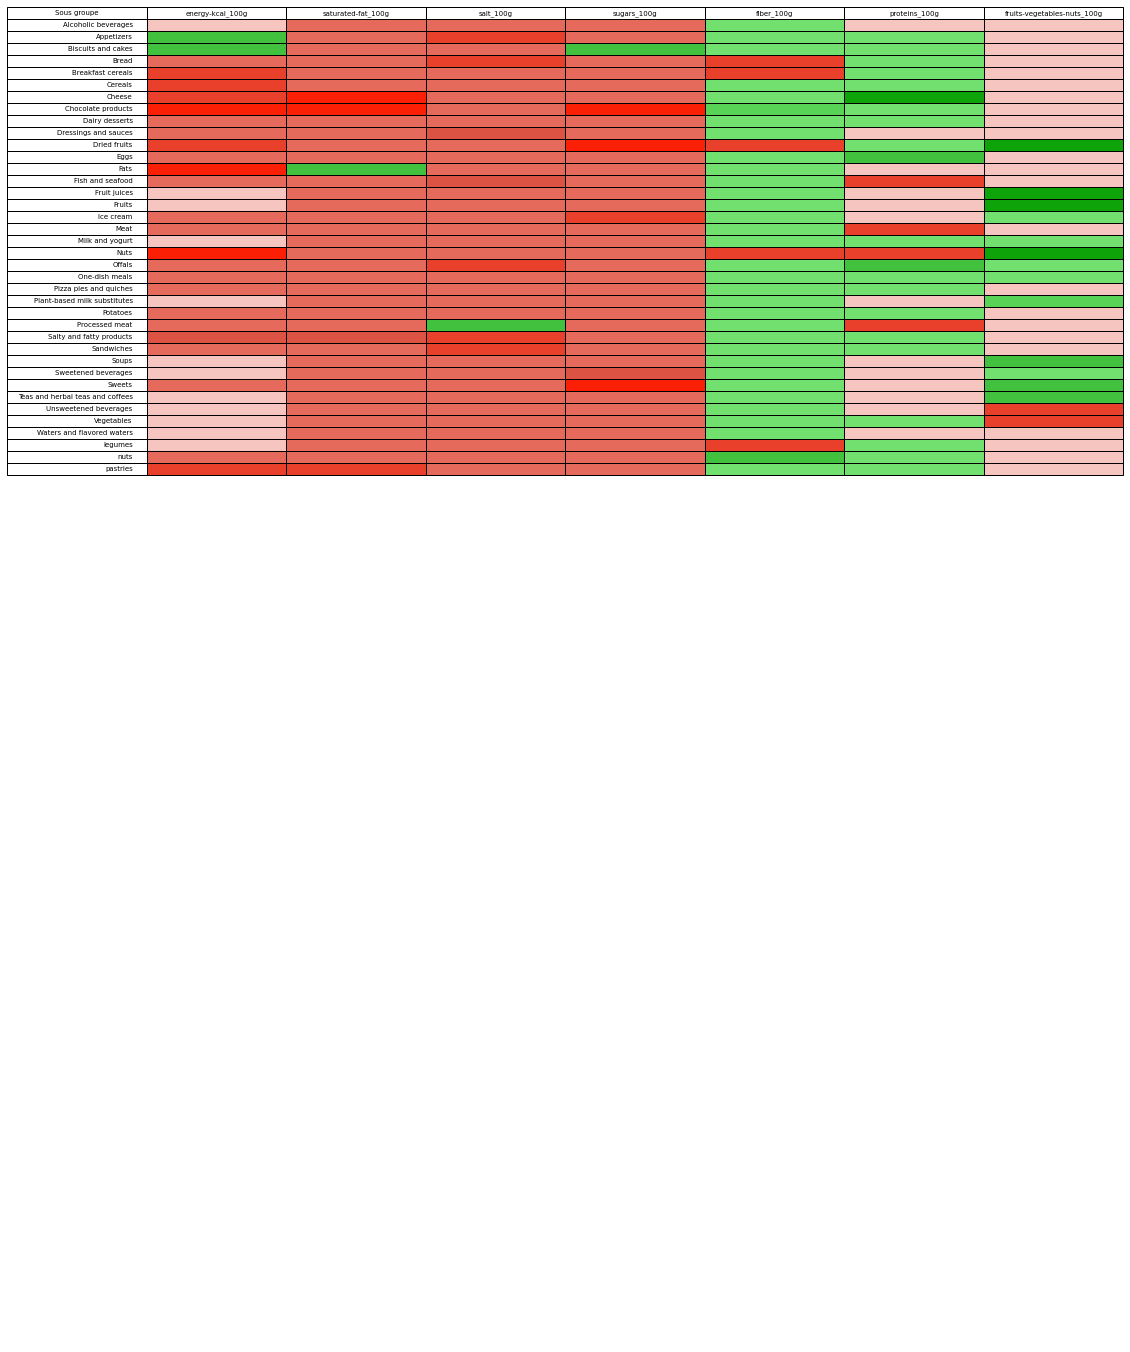

In [252]:
plotSynopsys(synopsys)

<p>La répartition des produits en sous groupe permet de les classifier par mode d'utilisation dans le cadre de la préparation d'un repas, ce qui est compréhensible pour un particulier. Toutefois on a montré que pour un même sous-groupe la qualité du produit est fonction de la feature selon laquelle on le considère, et au sein même de chaque feature la variabilité peut être importante.</p>
<p>D'autre part certains produits pourront présenter des qualités au regard de certaines features, mais être en contradiction pour d'autres se qui se voit très bien sur la synthèse. Par exemple le fromage (Cheese) est un sous groupe négativement très marqué par rapport aux features Lipides saturés et sel, mais positivement très marqué par rapport aux protéines.</p> 
<p>Il faut alors mettre le produit en perspective par rapport au sous-groupe auquel il appartient dans le contexte dans lequel on l'utilise (ingrédient principal ou non, dosage limité, utilisé pour son apport en tel ou tel nutriment, etc ... ). L'application devrait permettre de tenir compte de ces paramètres.</p>

<b style="background-color:tomato;font-size:14px;">6. ANALYSE FACTORIELLE<b>
    <a id="factorial"></a> 

Au point précédent on a pu mettre en évidence des valeurs de score nutritionnel élevées (mauvais score) et disparates en fonction des principales catégories de produit
Il apparait nécessaire toutefois d'affiner dans l'objectif de permettre à notre application d'offrir une granularité plus fine (ingrédient brut).
Pour cela on va dégager les catégories principales de notre dataset par analyse acp et montrer les mesures de variation qui leur sont liées.
################# ici intérêt acp est de faire ressortir les catégories de produit et comment elles se situent par rapport au nutriscore pour permettre à l'utilisateur de l'application de pouvoir faire son choix (proposition d'alternative avec un produit de la même catégorie mais avec meilleur nutriscore)

In [272]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, limit=10, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                    if i == limit:
                        break
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des aliments (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.axhline(y=1, color='blue', linestyle='--',label="Règle de Kaiser")
    plt.legend()
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()


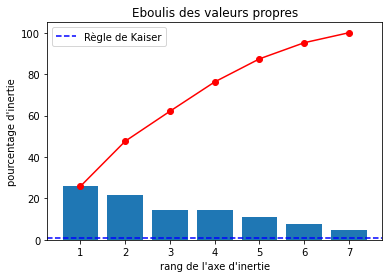

In [263]:

# init model
pca = PCA(n_components=2)

# choix du nombre de composantes à calculer
n_comp = 7

# import de l'échantillon
food=data

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[['energy-kcal_100g',
 'saturated-fat_100g',
'salt_100g',
'sugars_100g',
'fiber_100g',
'proteins_100g',
'fruits-vegetables-nuts_100g']]


# préparation des données pour l'ACP
data_pca = data_pca.dropna()

X = data_pca.values

#features = data.columns
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

<p>Analyse de l'éboulis : </p>
<p>On retient les 7 axes qui expliquent 100% de l'inertie sans qu'on constate d'inflexion dans la courbe de variabilité. D'autre part toutes valeurs sont supérieures à 1% (règle de Kaiser)</p>
<p>On peut construire les cercles de correlation.</p>

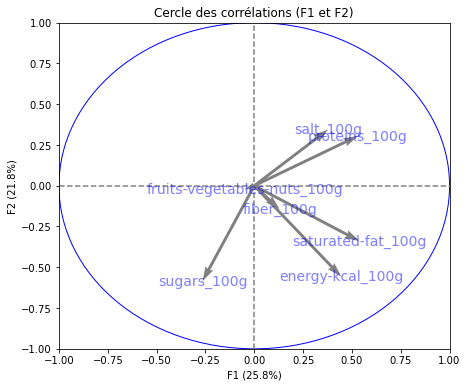

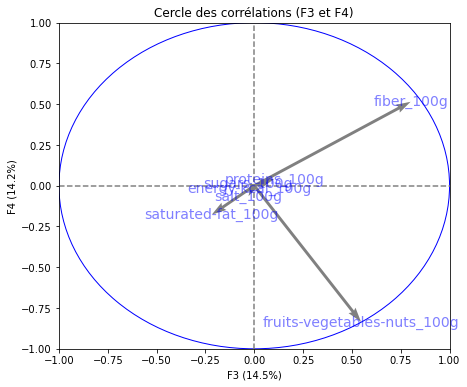

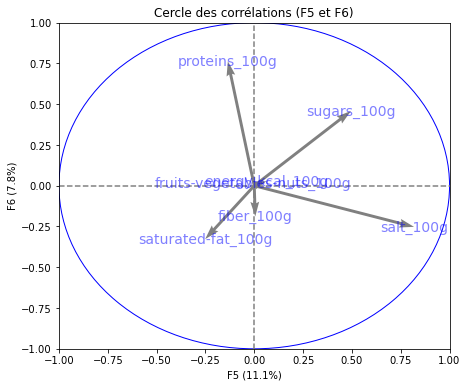

In [268]:
# Cercle des corrélations
pcs = pca.components_

display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5),(6,7),(8,9),(10,11),(12,13),(14,15),(16,17),(18,19),(20,21),(22,23),(24,25)], labels = np.array(features))
#display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

plt.show()

        
<p><b>Cercle de corrélations 1</b></p>        
<p>Dans ce cercle on constate 3 composantes principales:</p>
<p>&nbsp;&nbsp;&nbsp;- une corrélation positive avec Matières grasses saturées et énergie qui mesure donc l'impact énergétique d'un produit en rapport à son taux de matières grasses saturées</p>
<p>&nbsp;&nbsp;&nbsp;- une corrélation positive avec sel et protéines qui est en corrélation négative avec le sucre et qui mesure l'absence de sucre dans des produits salés et/ou protéinés</p>

<p><b>Cercle de corrélations 2</b></p>
<p>Dans ce cercle on constate 2 composantes principales:</p>
<p>&nbsp;&nbsp;&nbsp;- un axe caractérisé par les fruits légumes noix (les produits projetés sur cet axe seront riches en fruits légumes noix)</p>
<p>&nbsp;&nbsp;&nbsp;- un axe caractérisé par les fibres (les produits projetés sur cet axe seront riches en fibres)</p>

<p><b>Cercle de corrélations 3</b></p>        
<p>Dans ce cercle on constate 3 composantes principales:</p>
<p>&nbsp;&nbsp;&nbsp;- un axe caractérisé par les protéines (les produits projetés sur cet axe seront riches en protéines)</p>
<p>&nbsp;&nbsp;&nbsp;- un axe caractérisé par le sucre (les produits projetés sur cet axe seront riches en sucre)</p>
<p>&nbsp;&nbsp;&nbsp;- un axe caractérisé par le sel (les produits projetés sur cet axe seront riches en sel)</p>



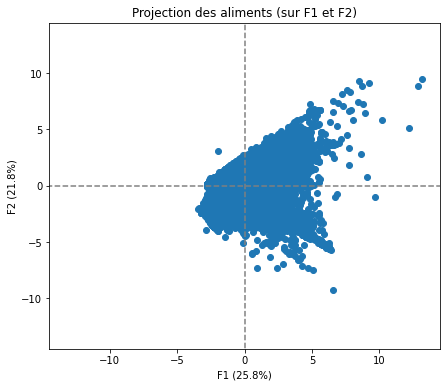

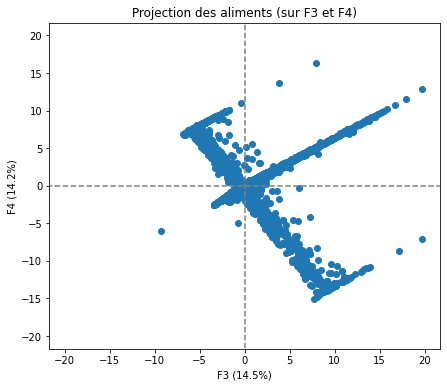

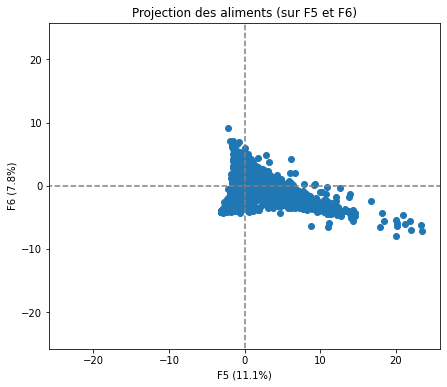

In [273]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5),(6,7),(8,9),(10,11),(12,13),(14,15),(16,17),(18,19),(20,21),(22,23),(24,25)])

plt.show()

<b style="background-color:tomato;font-size:14px;">7 SIMULATION D'APPLICATION<b>
    <a id="application"></a> 

<p>Les analyses que nous avons menées sur le dataset ont permis d'identifier comment jouer sur les sous-groupes de produits dont on a expliqué leur fonctionnement interne, et décrit leur interaction avec le score nutritionnel.</p>

<p>L'idée de départ de l'application était d'aider une personne à améliorer le score nutritionnel global du repas en proposant des alternatives. Pour chaque produit composant le repas il serait intéressant de proposer une alternative équivalente "culinairement parlant" soit dans le même sous-groupe, soit dans un autre sous-groupe si celui-ci est un facteur d'amélioration, avec pour objectif d'une part d'améliorer le score nutritionnel, mais aussi d'aller dans le sens des recommandations du Ministère.</p>

<p>Ici nous simulons cette application, les recherches ne sont pas implémentées.</p>

In [275]:
def spider(values, cat, ax):
    from math import pi
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]
    # for circularity
    values += values[:1]
    x_as += x_as[:1]
    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Set position of y-labels
    ax.set_rlabel_position(0)
    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    # Set ticks values and labels    
    ax.set_xticks(x_as[:-1])
    ax.set_xticklabels([])
    ax.set_yticks([0.1, 0.5, 1, 2, 10])
    ax.set_yticklabels(["0.1", "0.5", "1", "2", "10"])
    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)
    # Fill area
    ax.fill(x_as, values, 'b', alpha=0.3)
    # Set axes limits
    ax.set_ylim(0, 3)
    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 3
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        elif angle_rad == pi:
            ha, distance_ax = "center", 3
        else:
            ha, distance_ax = "right", 3

        ax.text(angle_rad, 0.2+distance_ax, cat[i], size=10,
                horizontalalignment=ha, verticalalignment="center")

In [303]:
def showMenuProjection(dishes):
    for d in dishes:
        print(d + ': ' + data.loc[data['product_name'].str.lower() == d]['pnns_groups_3'].values[0])
    
    fig, axes = plt.subplots(nrows=3, ncols=3, subplot_kw=dict(projection='polar'), figsize=(11,11))
    axes = np.array(axes)

    liste_columns = ['nutrition-score-fr_100g','saturated-fat_100g','proteins_100g','salt_100g','fruits-vegetables-nuts_100g','energy-kcal_100g','sugars_100g','fiber_100g']
    list_nutriments = [s.strip('_100g') for s in liste_columns]

    df_chart = data[pd.notnull(data[liste_columns]).all(axis = 1)]
    mean_values = list(df_chart[liste_columns].mean().values)

    ind = 0
    for ax in axes.reshape(-1):
        dish = df_chart.loc[df_chart['product_name'].str.lower() == dishes[ind]]
        absolute_values = list(dish.iloc[0][liste_columns].T.values)        
        values  = [ val/mean_values[i] for i, val in enumerate(absolute_values)]
        spider(values, list_nutriments, ax)
        ax.set_title(dish.iloc[0].product_name+'\n', fontsize = 12)
        
        ind += 1
        if ind > (len(dishes)-1):
            break
        
    fig.subplots_adjust(hspace=0.5,wspace=1)
    plt.show()

chips: Appetizers
whisky: Alcoholic beverages
salade cesar: Vegetables
tartiflette: One-dish meals
camembert: Cheese
mousse au chocolat: Dairy desserts
vin rouge: Alcoholic beverages


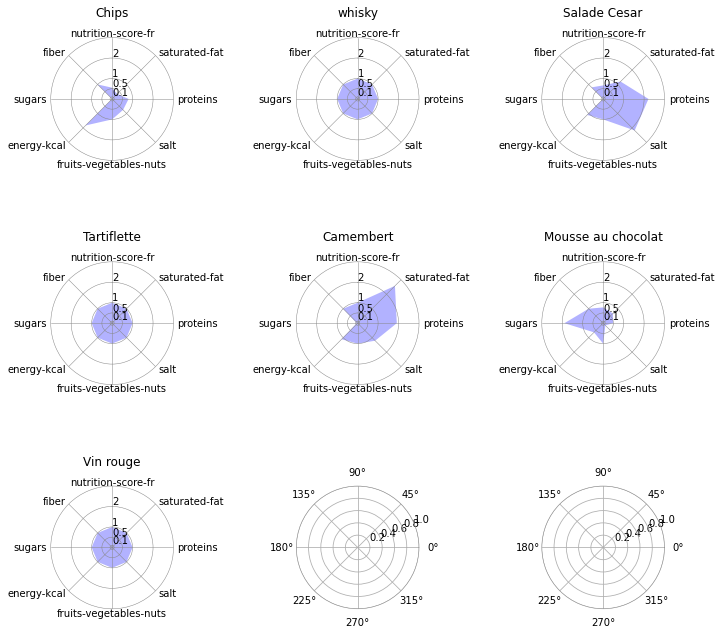

In [311]:
dishes=['chips','whisky','salade cesar','tartiflette','camembert','mousse au chocolat','vin rouge']
showMenuProjection(dishes)

noix de pécan: Nuts
jus de pomme: Fruit juices
carottes rapées: One-dish meals
cuisse de poulet: Meat
yaourt: Milk and yogurt
riz au lait: Dairy desserts
badoit: Waters and flavored waters


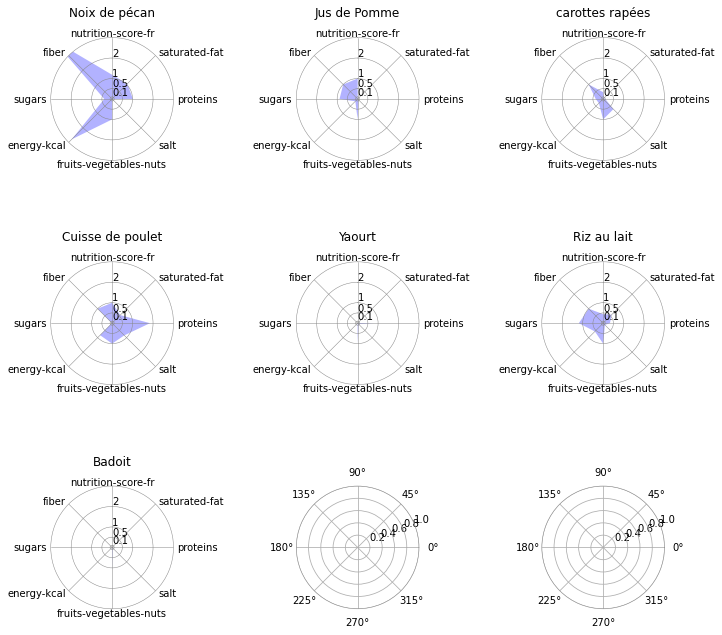

In [312]:
dishes=['noix de pécan','jus de pomme','carottes rapées','cuisse de poulet','yaourt','riz au lait','badoit']
showMenuProjection(dishes)

In [13]:
del data